# DDPM from Scratch: Theory to Implementation

## A Complete Guide to Denoising Diffusion Probabilistic Models

**Based on the paper**: *Denoising Diffusion Probabilistic Models* (Ho et al., 2020)

---

### 📚 Learning Objectives

By the end of this notebook, you will:

1. ✅ Understand the **mathematical foundation** of diffusion models
2. ✅ Map each **equation from the DDPM paper** to working code
3. ✅ Implement the **forward diffusion process** (adding noise)
4. ✅ Implement the **reverse diffusion process** (denoising with a neural network)
5. ✅ Build a **UNet architecture** with time conditioning
6. ✅ Train a complete diffusion model on **MNIST**
7. ✅ Generate new images from random noise
8. ✅ Understand the connection between **variational inference** and the training objective

---

### 🎯 Prerequisites

**Mathematics:**
- Basic probability (Gaussian distributions, conditional probability)
- Basic calculus (derivatives, chain rule)
- Understanding of Bayes' theorem
- Familiarity with variational inference (helpful but not required)

**Programming:**
- PyTorch basics (tensors, autograd, nn.Module)
- Training neural networks
- Basic CNN knowledge

---

### 📖 Paper Reference

**DDPM Paper**: [Denoising Diffusion Probabilistic Models (NeurIPS 2020)](https://arxiv.org/abs/2006.11239)

We will reference specific equations from the paper throughout this notebook.

## 1. Environment Setup

Let's set up our environment with all necessary imports and ensure reproducibility.

In [1]:
# Standard library
import os
import math
import warnings
from pathlib import Path

# Scientific computing
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# ============================================================================
# REPRODUCIBILITY: Set random seeds
# ============================================================================
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # For reproducibility on CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ============================================================================
# DEVICE SETUP
# ============================================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")

if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ CUDA Version: {torch.version.cuda}")

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def print_gpu_memory():
    """Print current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3  # GB
        reserved = torch.cuda.memory_reserved() / 1024**3    # GB
        print(f"GPU Memory: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved")

def create_output_dir(path="outputs"):
    """Create output directory for saving results"""
    Path(path).mkdir(parents=True, exist_ok=True)
    print(f"✓ Output directory: {path}")
    return path

# Create output directories
output_dir = create_output_dir("../outputs")
checkpoint_dir = create_output_dir("../checkpoints")

print("\n" + "="*60)
print("✅ Environment setup complete!")
print("="*60)


✓ Using device: cuda
✓ GPU: NVIDIA A100 80GB PCIe
✓ CUDA Version: 12.6
✓ Output directory: ../outputs
✓ Output directory: ../checkpoints

✅ Environment setup complete!


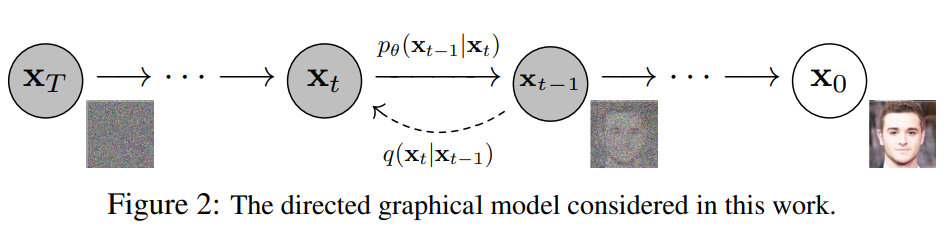

---

# 2. Theory Foundation

## 2.1 What is a Diffusion Model?

### Intuition

Imagine you have a clear image of a handwritten digit. Now imagine gradually adding random noise to it over many steps until it becomes pure noise (like TV static). A **diffusion model** learns to **reverse this process** - it learns to denoise step by step, turning pure noise back into a clear image.

```
Forward Process (Easy):  Clear Image → Noisy → Noisier → ... → Pure Noise
Reverse Process (Hard):  Pure Noise → ... → Less Noisy → Clear Image
```

The key insight: if we can learn to denoise step by step, we can **generate new images** by starting from random noise!

### Two Processes

1. **Forward Process (Fixed)**: Gradually adds noise to data
   - We don't need to learn this - it's just adding Gaussian noise!
   - Denoted as $q(x_t | x_{t-1})$

2. **Reverse Process (Learned)**: Gradually removes noise
   - This is what we train a neural network to do
   - Denoted as $p_\theta(x_{t-1} | x_t)$
   - $\theta$ represents the neural network parameters

### Notation

- $x_0$: Real data (e.g., a clear MNIST digit)
- $x_1, x_2, ..., x_T$: Progressively noisier versions
- $x_T$: Pure Gaussian noise
- $T$: Total number of timesteps (e.g., 1000)
- $t$: Current timestep (0 to T)
- $\beta_t$: Noise schedule (how much noise to add at step $t$)
- $\epsilon$: Random noise sampled from $\mathcal{N}(0, I)$

## 2.2 Forward Process: Adding Noise

### Paper Equation (2) - Forward Process

The forward process adds Gaussian noise at each timestep:

$$
q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} \cdot x_{t-1}, \beta_t \cdot I)
$$

**Translation**: Given $x_{t-1}$, we get $x_t$ by:
- Mean: $\sqrt{1 - \beta_t} \cdot x_{t-1}$ (slightly shrink the image)
- Variance: $\beta_t \cdot I$ (add noise with variance $\beta_t$)

### Sampling Formula

To sample $x_t$ from $x_{t-1}$:

$$
x_t = \sqrt{1 - \beta_t} \cdot x_{t-1} + \sqrt{\beta_t} \cdot \epsilon \quad \text{where} \quad \epsilon \sim \mathcal{N}(0, I)
$$

### Key Variables

Define $\alpha_t = 1 - \beta_t$ for convenience:

$$
\alpha_t = 1 - \beta_t
$$

Then:
$$
x_t = \sqrt{\alpha_t} \cdot x_{t-1} + \sqrt{1 - \alpha_t} \cdot \epsilon
$$

### Cumulative Product (This is the Magic!)

Define the **cumulative product**:

$$
\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s = \alpha_1 \cdot \alpha_2 \cdot ... \cdot \alpha_t
$$

**Paper Equation (4) - Closed Form**:

We can jump directly from $x_0$ to $x_t$ without computing intermediate steps:

$$
q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} \cdot x_0, (1 - \bar{\alpha}_t) \cdot I)
$$

**Sampling form**:
$$
x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon
$$

**This is crucial for implementation!** We can sample any noisy version $x_t$ directly from the original $x_0$.

<!-- ### Why This Works (Brief Derivation)

Starting from $x_1 = \sqrt{\alpha_1} x_0 + \sqrt{1-\alpha_1} \epsilon_1$:

$$
\begin{align}
x_2 &= \sqrt{\alpha_2} x_1 + \sqrt{1-\alpha_2} \epsilon_2 \\
    &= \sqrt{\alpha_2}(\sqrt{\alpha_1} x_0 + \sqrt{1-\alpha_1} \epsilon_1) + \sqrt{1-\alpha_2} \epsilon_2 \\
    &= \sqrt{\alpha_2 \alpha_1} x_0 + \sqrt{\alpha_2(1-\alpha_1)} \epsilon_1 + \sqrt{1-\alpha_2} \epsilon_2
\end{align}
$$

Since $\epsilon_1, \epsilon_2$ are independent Gaussians, we can merge them:
$$
x_2 = \sqrt{\bar{\alpha}_2} x_0 + \sqrt{1 - \bar{\alpha}_2} \bar{\epsilon}
$$

This pattern continues for all $t$! -->

### 📐 Detailed Derivation: Closed Form

Let's prove why we can jump directly from $x_0$ to $x_t$.

**Given**: Sequential noising process
$$
x_t = \sqrt{\alpha_t} \cdot x_{t-1} + \sqrt{1 - \alpha_t} \cdot \epsilon_{t-1}
$$

**Goal**: Express $x_t$ in terms of $x_0$ only.

**Step 1**: Start with $t=1$
$$
x_1 = \sqrt{\alpha_1} \cdot x_0 + \sqrt{1 - \alpha_1} \cdot \epsilon_0
$$

**Step 2**: Apply the formula for $t=2$
$$
\begin{align}
x_2 &= \sqrt{\alpha_2} \cdot x_1 + \sqrt{1 - \alpha_2} \cdot \epsilon_1 \\
    &= \sqrt{\alpha_2} \cdot (\sqrt{\alpha_1} x_0 + \sqrt{1-\alpha_1} \epsilon_0) + \sqrt{1-\alpha_2} \epsilon_1 \\
    &= \sqrt{\alpha_2 \alpha_1} \cdot x_0 + \sqrt{\alpha_2(1-\alpha_1)} \cdot \epsilon_0 + \sqrt{1-\alpha_2} \cdot \epsilon_1
\end{align}
$$

**Step 3**: Merge the Gaussian noise terms

Since $\epsilon_0 \sim \mathcal{N}(0, I)$ and $\epsilon_1 \sim \mathcal{N}(0, I)$ are independent:
$$
\sqrt{\alpha_2(1-\alpha_1)} \cdot \epsilon_0 + \sqrt{1-\alpha_2} \cdot \epsilon_1 \sim \mathcal{N}(0, [\alpha_2(1-\alpha_1) + (1-\alpha_2)] I)
$$

Simplify the variance:
$$
\begin{align}
\alpha_2(1-\alpha_1) + (1-\alpha_2) &= \alpha_2 - \alpha_2\alpha_1 + 1 - \alpha_2 \\
&= 1 - \alpha_2\alpha_1 \\
&= 1 - \bar{\alpha}_2
\end{align}
$$

Therefore:
$$
x_2 = \sqrt{\bar{\alpha}_2} \cdot x_0 + \sqrt{1 - \bar{\alpha}_2} \cdot \bar{\epsilon}
$$

where $\bar{\epsilon} \sim \mathcal{N}(0, I)$ is the merged noise.

**Step 4**: By induction, this holds for any $t$:

$$
\boxed{x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon \quad \text{where} \quad \epsilon \sim \mathcal{N}(0, I)}
$$

This is **Equation (4)** from the DDPM paper!

**Key Property**: The noising process is **Markovian** (each step only depends on the previous), but we can compute any step directly from $x_0$!

## 2.3 Reverse Process: Removing Noise

### The Goal

To generate images, we need to reverse the forward process. Given a noisy image $x_t$, we want to find the slightly less noisy image $x_{t-1}$.

### Paper Equation (2) - Reverse Process

$$
p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))
$$

**Translation**: Model the reverse step as a Gaussian distribution where:
- $\mu_\theta(x_t, t)$: Mean predicted by neural network
- $\Sigma_\theta(x_t, t)$: Variance (we'll use fixed variance from paper)

### The True Posterior: $q(x_{t-1}|x_t, x_0)$

Using Bayes' rule, we can compute the **true posterior** if we know both $x_t$ and $x_0$:

$$
q(x_{t-1}|x_t, x_0) = \frac{q(x_t|x_{t-1}, x_0) \cdot q(x_{t-1}|x_0)}{q(x_t|x_0)}
$$

Since the forward process is Markovian:
$$
q(x_t|x_{t-1}, x_0) = q(x_t|x_{t-1})
$$

### Computing the Posterior Distribution

From the forward process (Equation 2):
$$
q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{\alpha_t} x_{t-1}, (1-\alpha_t) I)
$$

From the closed form (Equation 4):
$$
\begin{align}
q(x_{t-1} | x_0) &= \mathcal{N}(x_{t-1}; \sqrt{\bar{\alpha}_{t-1}} x_0, (1-\bar{\alpha}_{t-1}) I) \\
q(x_t | x_0) &= \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t) I)
\end{align}
$$

After applying Bayes' rule and completing the square (algebra omitted, see paper appendix), we get:

$$
q(x_{t-1}|x_t, x_0) = \mathcal{N}(x_{t-1}; \tilde{\mu}_t(x_t, x_0), \tilde{\beta}_t I)
$$

where the **posterior mean** is:

### Paper Equation (7) - Posterior Mean $\tilde{\mu}_t$

$$
\tilde{\mu}_t(x_t, x_0) = \frac{\sqrt{\bar{\alpha}_{t-1}} \beta_t}{1 - \bar{\alpha}_t} x_0 + \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_t
$$

and the **posterior variance** is:

$$
\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t
$$

**Interpretation**: The posterior mean is a weighted combination of:
1. The clean image $x_0$ (weighted by how much signal is expected at $t-1$)
2. The noisy image $x_t$ (weighted by how much we trust the current observation)

### The Problem: We Don't Know $x_0$!

During generation, we only have $x_t$, not $x_0$. But from Equation (4), we can express $x_0$ in terms of $x_t$ and $\epsilon$:

$$
x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon
$$

Rearranging:
$$
\boxed{x_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} \left( x_t - \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon \right)}
$$

### Paper Equation (11) - Predicted Mean

Substituting this $x_0$ into $\tilde{\mu}_t$ and simplifying (see paper for details):

$$
\boxed{\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right)}
$$

**Key Insight**: If we train a neural network $\epsilon_\theta(x_t, t)$ to predict the noise $\epsilon$, we can compute the mean $\mu_\theta$ needed for the reverse process!

### Summary of Reverse Process

To sample $x_{t-1}$ from $x_t$:

1. Predict noise: $\epsilon_\theta(x_t, t)$
2. Compute mean using Equation (11)
3. Sample: $x_{t-1} = \mu_\theta(x_t, t) + \sigma_t z$ where $z \sim \mathcal{N}(0, I)$

<!-- This is **Algorithm 2** in the paper! -->

### Training

Diffusion model is generative model to estimate **data distribution $q(\mathbf{x}_0)$**
--> The goal is to train a probability model $p_\theta(\mathbf{x}_0)$ that can generate samples similar to real data $x_0$

### ✅ Problem is?

$p_\theta(\mathbf{x}_0)$ is intractable, which means
to compute $p_\theta(\mathbf{x}_0)$ directly, we need to integrate over the latent variables $\mathbf{x}_{1:T}$ :

$$
p_\theta(\mathbf{x}_0)
= \int p_\theta(\mathbf{x}_{0:T})\,d\mathbf{x}_{1:T}
= \int p(\mathbf{x}_T)\prod_{t=1}^{T}p_\theta(\mathbf{x}_{t-1}\mid\mathbf{x}_t)\,d\mathbf{x}_{1:T}
$$

This integral involves all high-dimensional probabilistic paths across T steps, **making direct computation impossible".**
--> Therefore, we use **Variational Inference (VI)** to approximate it.

In other words, instead of directly modeling the complex $p_\theta(\mathbf{x}_0)$,
we train each conditional distribution $p_\theta(\mathbf{x}_{t-1}\mid\mathbf{x}_t)$, which is the core practical strategy of diffusion model training

---

### 🧮 Jensen’s Inequality and ELBO Derivation

### ✅ Jensen’s Inequality (for concave log)

$$
\log \mathbb{E}[X] \ge \mathbb{E}[\log X]
$$

This inequality allows us to approximate the intractable $\log p_\theta(\mathbf{x}_0)$ in the form of an expectation.

---

### ✅ Step 1: Multiply and divide by $q(\mathbf{x}_{1:T}\mid\mathbf{x}_0)$ 

$$
\log p_\theta(\mathbf{x}_0)
= \log \int 
q(\mathbf{x}_{1:T}\mid \mathbf{x}_0)
\frac{p_\theta(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T}\mid \mathbf{x}_0)}
\, d\mathbf{x}_{1:T}
$$

We can rewrite this integral as an expectation:

$$
= \log 
\mathbb{E}_{q(\mathbf{x}_{1:T}\mid \mathbf{x}_0)}
\!\left[
\frac{p_\theta(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T}\mid \mathbf{x}_0)}
\right]
$$
---

---

---

## ✅ Step 2: Apply Jensen’s Inequality — Deriving the ELBO

From the previous step, we have:

$$
\log p_\theta(\mathbf{x}_0)
= \log 
\mathbb{E}_{q(\mathbf{x}_{1:T}|\mathbf{x}_0)}
\!\left[
\frac{p_\theta(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T}|\mathbf{x}_0)}
\right]
$$

Since the log function is concave, we can apply Jensen’s Inequality::

$$
\log \mathbb{E}[X] \ge \mathbb{E}[\log X]
$$

Applying this gives us,

$$
\log p_\theta(\mathbf{x}_0)
\ge 
\mathbb{E}_{q(\mathbf{x}_{1:T}|\mathbf{x}_0)}
\!\left[
\log 
\frac{p_\theta(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T}|\mathbf{x}_0)}
\right]
$$

👉 The right-hand side is called the **Evidence Lower Bound (ELBO)**.

---

### 🔹 ELBO

The ELBO serves as a computable lower bound on the model’s log-likelihood on the model's log-likelihood $\log p_\theta(\mathbf{x}_0)$
Maximizing the ELBO effectively maximizes the log-likelihood.

<table style="width:100%; border-collapse:collapse;">
  <tr>
    <th style="width:25%; text-align:center; border-bottom:1px solid #ccc;">Term</th>
    <th style="width:35%; text-align:center; border-bottom:1px solid #ccc;">Formula</th>
    <th style="width:40%; text-align:center; border-bottom:1px solid #ccc;">Description</th>
  </tr>
  <tr>
    <td style="text-align:center;">Evidence</td>
    <td style="text-align:center; white-space:nowrap;">$p_\theta(\mathbf{x}_0)$</td>
    <td style="text-align:left;">Probability that the model explains the data $\mathbf{x}_0$</td>
  </tr>
  <tr>
    <td style="text-align:center;">Lower Bound</td>
    <td style="text-align:center; white-space:nowrap;">$\mathbb{E}_q[\log p_\theta - \log q]$</td>
    <td style="text-align:left;">A computable approximation</td>
  </tr>
  <tr>
    <td style="text-align:center;">ELBO</td>
    <td style="text-align:center; white-space:nowrap;">$\text{ELBO} = \mathbb{E}_q[\log p_\theta(\mathbf{x}_{0:T}) - \log q(\mathbf{x}_{1:T}|\mathbf{x}_0)]$</td>
    <td style="text-align:left;">A computable approximation specified in diffusion</td>
  </tr>
</table>

---

### Detailed ELBO Expansion

Let's expand the ELBO step by step. We start from:

$$
\text{ELBO} = \mathbb{E}_{q(x_{1:T}|x_0)} \left[ \log \frac{p_\theta(x_{0:T})}{q(x_{1:T}|x_0)} \right]
$$

**Step 1**: Expand the joint distributions using chain rule

Forward process (given, fixed):
$$
q(x_{1:T}|x_0) = \prod_{t=1}^{T} q(x_t|x_{t-1})
$$

Reverse process (learned):
$$
p_\theta(x_{0:T}) = p(x_T) \prod_{t=1}^{T} p_\theta(x_{t-1}|x_t)
$$

**Step 2**: Substitute into ELBO

$$
\begin{align}
\text{ELBO} &= \mathbb{E}_{q} \left[ \log \frac{p(x_T) \prod_{t=1}^{T} p_\theta(x_{t-1}|x_t)}{\prod_{t=1}^{T} q(x_t|x_{t-1})} \right] \\
&= \mathbb{E}_{q} \left[ \log p(x_T) + \sum_{t=1}^{T} \log p_\theta(x_{t-1}|x_t) - \sum_{t=1}^{T} \log q(x_t|x_{t-1}) \right]
\end{align}
$$

**Step 3**: Rearrange by introducing $q(x_{t-1}|x_t, x_0)$

The key trick is to rewrite the forward process using Bayes' rule:

$$
q(x_t|x_{t-1}) = \frac{q(x_{t-1}|x_t, x_0) q(x_t|x_0)}{q(x_{t-1}|x_0)}
$$

After substituting and lots of algebra (telescoping sums, see DDPM paper appendix), we get:

$$
\begin{align}
\text{ELBO} &= \mathbb{E}_{q} \Bigg[
    \log p(x_T) \\
    &\quad + \sum_{t=2}^{T} \log \frac{p_\theta(x_{t-1}|x_t)}{q(x_{t-1}|x_t, x_0)} \\
    &\quad + \log \frac{p_\theta(x_0|x_1)}{q(x_1|x_0)}
\Bigg]
\end{align}
$$

**Step 4**: Convert log ratios to KL divergences

Recall that $D_{KL}(p \| q) = \mathbb{E}_p[\log p - \log q]$, so:

$$
\log \frac{p}{q} = \log p - \log q
$$

Therefore, we can write:

$$
\begin{align}
\text{ELBO} &= \mathbb{E}_{q} \Bigg[
    \underbrace{\log \frac{p(x_T)}{q(x_T|x_0)}}_{-D_{KL}(q(x_T|x_0) \| p(x_T))} \\
    &\quad + \sum_{t=2}^{T} \underbrace{\log \frac{p_\theta(x_{t-1}|x_t)}{q(x_{t-1}|x_t, x_0)}}_{-D_{KL}(q(x_{t-1}|x_t,x_0) \| p_\theta(x_{t-1}|x_t))} \\
    &\quad + \underbrace{\log p_\theta(x_0|x_1)}_{\text{reconstruction}}
\Bigg]
\end{align}
$$

**Step 5**: Final form - Paper Equation (5)

Rearranging to minimize (negative ELBO), we get the **loss function**:


## 2.4 Training Objective

### Starting Point: Log-Likelihood

We want to maximize the probability of real data:

$$
\max_\theta \mathbb{E}_{x_0 \sim q(x_0)} \left[ \log p_\theta(x_0) \right]
$$

But $p_\theta(x_0) = \int p_\theta(x_{0:T}) dx_{1:T}$ is intractable!

### Solution: Variational Lower Bound (ELBO)

Using variational inference:

$$
\log p_\theta(x_0) \geq \mathbb{E}_{q(x_{1:T}|x_0)} \left[ \log \frac{p_\theta(x_{0:T})}{q(x_{1:T}|x_0)} \right] = \text{ELBO}
$$

**Paper Equation (5)** - Loss Decomposition:

From the ELBO expansion above, we get:

$$
L = \mathbb{E}_q \left[ 
    \underbrace{D_{KL}(q(x_T|x_0) \| p(x_T))}_{L_T} +
    \sum_{t=2}^T \underbrace{D_{KL}(q(x_{t-1}|x_t,x_0) \| p_\theta(x_{t-1}|x_t))}_{L_{t-1}} 
    \underbrace{- \log p_\theta(x_0|x_1)}_{L_0}
\right]
$$

- $L_T$: Constant (no parameters), can be ignored
- $L_{t-1}$: Denoising matching loss
- $L_0$: Reconstruction term

### Why We Can Ignore Some Terms

The full loss has three components. Let's understand each and **why we only optimize $L_{t-1}$**:

#### 1️⃣ $L_T$ Term: **Can be Ignored** ✓

$$
L_T = D_{KL}(q(x_T|x_0) \| p(x_T))
$$

**What it means**: How different is our final noised sample $x_T$ from pure Gaussian noise?

**Why we ignore it**:
- ✅ **No learnable parameters** ($\theta$ doesn't appear)
- ✅ $q(x_T|x_0)$ is the forward process (fixed)
- ✅ $p(x_T) = \mathcal{N}(0, I)$ is just Gaussian (fixed)
- ✅ For large enough $T$ (e.g., 1000) and proper $\beta$ schedule, $q(x_T|x_0) \approx \mathcal{N}(0, I)$
- ✅ Therefore, $L_T \approx 0$ (negligible)

**Paper justification**:
> "Since the forward process variances $\beta_t$ are fixed, $L_T$ is constant and can be ignored during training."
> — DDPM Paper

**In code**: We don't compute this at all during training!

---

#### 2️⃣ $L_{t-1}$ Terms: **This is what we optimize** ⭐

$$
L_{t-1} = \sum_{t=2}^{T} D_{KL}(q(x_{t-1}|x_t, x_0) \| p_\theta(x_{t-1}|x_t))
$$

**What it means**: For each timestep $t$, how well does our model $p_\theta$ match the true denoising distribution $q$?

**Why we DO optimize this**:
- ✅ **Contains $\theta$** (our model parameters)
- ✅ This is the **core denoising objective**
- ✅ Learns to reverse the diffusion process
- ✅ As we showed, this simplifies to predicting noise: $\|\epsilon - \epsilon_\theta\|^2$

**This is the only term we actually train!**

---

#### 3️⃣ $L_0$ Term: **Can be Ignored** ✓

$$
L_0 = -\log p_\theta(x_0|x_1)
$$

**What it means**: How well can we reconstruct the final clean image $x_0$ from $x_1$?

**Why we ignore it (or absorb it)**:

**Option 1: Ignore it completely** (Simple approach - what we do)
- When $T$ is large (e.g., 1000), $x_1$ is already very close to $x_0$
- The model learns this implicitly through $L_{t-1}$ terms
- Simplifies implementation significantly
- **Empirically works well!**

**Option 2: Use it as reconstruction term** (More principled)
- Model $p_\theta(x_0|x_1)$ as a decoder
- Would require a separate decoder head
- Adds complexity without much benefit for large $T$

**DDPM paper choice**:
> "We use a separate discrete decoder for $p_\theta(x_0|x_1)$ but find that it has negligible impact on sample quality."
> — DDPM Paper Section 3.3

**In simplified loss ($L_{\text{simple}}$)**: We ignore this entirely!

---

### Summary: Why $L_{\text{simple}}$ Works

From the full objective:
$$
L = \underbrace{L_T}_{\text{constant}} + \underbrace{\sum_{t=2}^{T} L_{t-1}}_{\text{optimize this!}} + \underbrace{L_0}_{\text{negligible}}
$$

We simplify to:
$$
L_{\text{simple}} = \mathbb{E}_{t \sim [2,T], x_0, \epsilon} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]
$$

**Practical implementation**:
1. Sample $t$ uniformly from $\{1, 2, ..., T\}$ (or even including $t=1$)
2. Compute one $L_{t-1}$ per training step
3. Over time, all timesteps are covered
4. Ignore $L_T$ and $L_0$ completely

**Result**:
- ✅ Simple MSE loss
- ✅ Easy to implement
- ✅ Empirically better than full objective (Table 1 in paper)
- ✅ No need for discrete decoder

This is why our training code is so clean:
```python
# That's it! Just predict noise.
loss = MSE(noise, predicted_noise)
```

No need to compute KL divergences, no need for $L_T$ or $L_0$ terms!

---


### Simplified Objective

**Paper Equation (14)** - The authors found this works better:

$$
L_{\text{simple}} = \mathbb{E}_{t, x_0, \epsilon} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]
$$

**Translation**: 
1. Take a real image $x_0$
2. Sample a random timestep $t$
3. Sample random noise $\epsilon$
4. Create noisy image: $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$
5. Predict the noise: $\epsilon_\theta(x_t, t)$
6. Compute MSE between true noise $\epsilon$ and predicted noise $\epsilon_\theta$

**This is just predicting noise!** Much simpler than the full ELBO.

## 2.5 Summary: Key Equations

Let's consolidate all key equations:

<table style='width:100%; border-collapse:collapse; border: 1px solid #ddd;'>
  <thead>
    <tr style='background-color: #f2f2f2;'>
      <th style='border: 1px solid #ddd; padding: 12px; text-align: left;'>Purpose</th>
      <th style='border: 1px solid #ddd; padding: 12px; text-align: left;'>Equation</th>
      <th style='border: 1px solid #ddd; padding: 12px; text-align: center;'>Paper Ref</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style='border: 1px solid #ddd; padding: 8px;'><strong>Forward step</strong></td>
      <td style='border: 1px solid #ddd; padding: 8px;'>$x_t = \sqrt{\alpha_t} x_{t-1} + \sqrt{1-\alpha_t} \epsilon$</td>
      <td style='border: 1px solid #ddd; padding: 8px; text-align: center;'>Eq. (1)</td>
    </tr>
    <tr style='background-color: #f9f9f9;'>
      <td style='border: 1px solid #ddd; padding: 8px;'><strong>Forward closed form</strong></td>
      <td style='border: 1px solid #ddd; padding: 8px;'>$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$</td>
      <td style='border: 1px solid #ddd; padding: 8px; text-align: center;'>Eq. (4)</td>
    </tr>
    <tr>
      <td style='border: 1px solid #ddd; padding: 8px;'><strong>Posterior mean</strong></td>
      <td style='border: 1px solid #ddd; padding: 8px;'>$\tilde{\mu}_t(x_t, x_0) = \frac{\sqrt{\bar{\alpha}_{t-1}} \beta_t}{1 - \bar{\alpha}_t} x_0 + \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_t$</td>
      <td style='border: 1px solid #ddd; padding: 8px; text-align: center;'>Eq. (7)</td>
    </tr>
    <tr style='background-color: #f9f9f9;'>
      <td style='border: 1px solid #ddd; padding: 8px;'><strong>Reverse step</strong></td>
      <td style='border: 1px solid #ddd; padding: 8px;'>$\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right)$</td>
      <td style='border: 1px solid #ddd; padding: 8px; text-align: center;'>Eq. (11)</td>
    </tr>
    <tr>
      <td style='border: 1px solid #ddd; padding: 8px;'><strong>Training loss</strong></td>
      <td style='border: 1px solid #ddd; padding: 8px;'>$L_{\text{simple}} = \mathbb{E}_{t, x_0, \epsilon} \left[ \|\epsilon - \epsilon_\theta(x_t, t)\|^2 \right]$</td>
      <td style='border: 1px solid #ddd; padding: 8px; text-align: center;'>Eq. (14)</td>
    </tr>
  </tbody>
</table>

### Pre-computed Values

For efficiency, we pre-compute these values for all timesteps:

```python
betas = ...  # β_t: noise schedule
alphas = 1 - betas  # α_t = 1 - β_t
alphas_cumprod = torch.cumprod(alphas, dim=0)  # ᾱ_t = ∏ α_s
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)  # √ᾱ_t
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)  # √(1-ᾱ_t)
```

Now let's implement this!

---

# 3. Beta Schedules

## 3.1 Why Do We Need a Noise Schedule?

The **beta schedule** $\{\beta_1, \beta_2, ..., \beta_T\}$ controls how much noise we add at each step.

**Requirements**:
- $\beta_t \in (0, 1)$ for all $t$
- Start small ($\beta_1 \approx 0.0001$): add little noise initially
- End larger ($\beta_T \approx 0.02$): add more noise at the end
- By step $T$, $x_T$ should be almost pure Gaussian noise

**Two popular schedules**:
1. **Linear**: $\beta_t$ increases linearly (original DDPM paper)
2. **Cosine**: $\beta_t$ derived from cosine function (Improved DDPM, Nichol & Dhariwal 2021)

## 3.2 Linear Beta Schedule

In [2]:
def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    """
    Linear beta schedule from DDPM paper.
    
    Beta increases linearly from beta_start to beta_end.
    
    Args:
        timesteps: Number of diffusion steps T
        beta_start: Starting beta value (default: 0.0001)
        beta_end: Ending beta value (default: 0.02)
    
    Returns:
        betas: Tensor of shape (timesteps,) with linear schedule
    """
    return torch.linspace(beta_start, beta_end, timesteps)

# Test it
T = 1000
betas_linear = linear_beta_schedule(T)

print(f"Linear schedule for T={T} steps:")
print(f"  β_1 = {betas_linear[0]:.6f}")
print(f"  β_500 = {betas_linear[499]:.6f}")
print(f"  β_1000 = {betas_linear[-1]:.6f}")
print(f"  Shape: {betas_linear.shape}")


Linear schedule for T=1000 steps:
  β_1 = 0.000100
  β_500 = 0.010040
  β_1000 = 0.020000
  Shape: torch.Size([1000])


## 3.3 Cosine Beta Schedule

From **Improved DDPM** (Nichol & Dhariwal, 2021):

Define a cosine schedule for $\bar{\alpha}_t$:

$$
\bar{\alpha}_t = \frac{f(t)}{f(0)}, \quad f(t) = \cos\left(\frac{t/T + s}{1 + s} \cdot \frac{\pi}{2}\right)^2
$$

Then derive $\beta_t$ from:

$$
\beta_t = 1 - \frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}}
$$

Parameter $s$ is a small offset (default 0.008) to prevent $\beta_t$ from being too small near $t=0$.

**Advantage**: Smoother noise increase, works better for high-resolution images.

In [3]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    Cosine beta schedule from Improved DDPM.
    
    Creates a smoother noise schedule using a cosine function.
    Paper: Improved Denoising Diffusion Probabilistic Models (Nichol & Dhariwal, 2021)
    
    Args:
        timesteps: Number of diffusion steps T
        s: Small offset to prevent beta from being too small (default: 0.008)
    
    Returns:
        betas: Tensor of shape (timesteps,) with cosine schedule
    """
    # Create timestep values from 0 to T
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps)
    
    # Compute alpha_bar using cosine schedule
    # f(t) = cos((t/T + s)/(1 + s) * π/2)^2
    alphas_cumprod = torch.cos(((t / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]  # Normalize so ᾱ_0 = 1
    
    # Compute betas from alpha_bar
    # β_t = 1 - (ᾱ_t / ᾱ_{t-1})
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    
    # Clip to prevent numerical issues
    betas = torch.clip(betas, 0.0001, 0.9999)
    
    return betas

# Test it
betas_cosine = cosine_beta_schedule(T)

print(f"\nCosine schedule for T={T} steps:")
print(f"  β_1 = {betas_cosine[0]:.6f}")
print(f"  β_500 = {betas_cosine[499]:.6f}")
print(f"  β_1000 = {betas_cosine[-1]:.6f}")
print(f"  Shape: {betas_cosine.shape}")



Cosine schedule for T=1000 steps:
  β_1 = 0.000100
  β_500 = 0.003146
  β_1000 = 0.999900
  Shape: torch.Size([1000])


## 3.4 Visualizing the Schedules

Let's compare linear vs cosine schedules by plotting:
- $\beta_t$: noise added at each step
- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$: cumulative product
- $1 - \bar{\alpha}_t$: total noise variance at step $t$

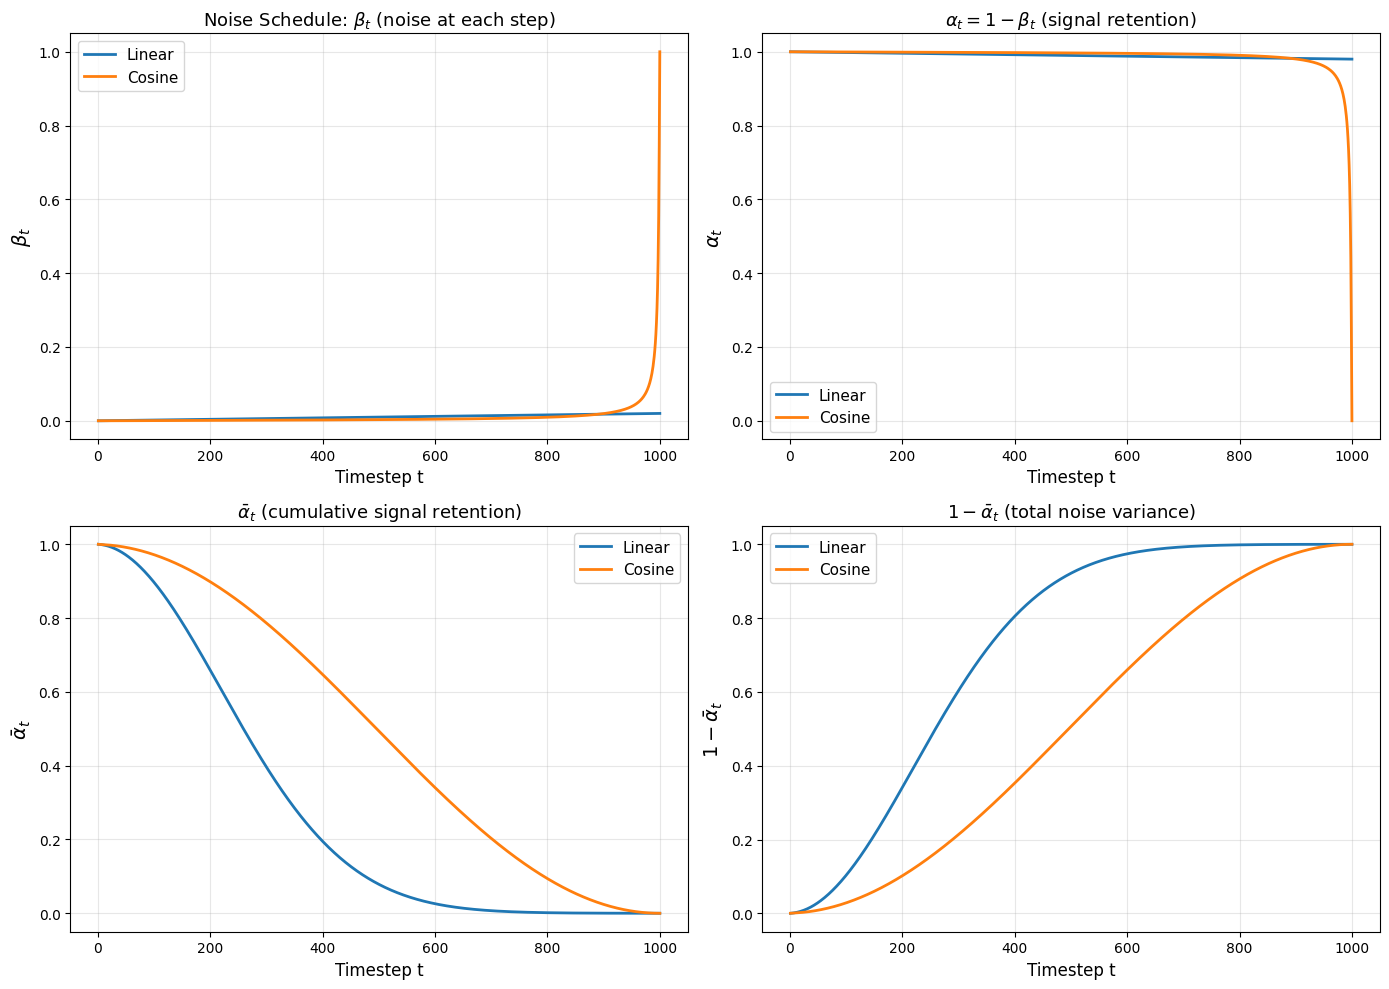


📊 Key Observations:
  Linear: ᾱ_T = 0.000040 (should be near 0)
  Cosine: ᾱ_T = 0.000000 (should be near 0)

  ✓ Both schedules reduce signal to near 0 at T=1000
  ✓ Cosine schedule is smoother, better for high-res images


In [4]:
def plot_noise_schedules(betas_linear, betas_cosine, timesteps=1000):
    """
    Visualize and compare linear vs cosine noise schedules.
    """
    # Compute derived quantities for both schedules
    alphas_linear = 1 - betas_linear
    alphas_cosine = 1 - betas_cosine
    
    alphas_cumprod_linear = torch.cumprod(alphas_linear, dim=0)
    alphas_cumprod_cosine = torch.cumprod(alphas_cosine, dim=0)
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    t = np.arange(1, timesteps + 1)
    
    # Plot 1: Beta_t
    axes[0, 0].plot(t, betas_linear, label='Linear', linewidth=2)
    axes[0, 0].plot(t, betas_cosine, label='Cosine', linewidth=2)
    axes[0, 0].set_xlabel('Timestep t', fontsize=12)
    axes[0, 0].set_ylabel(r'$\beta_t$', fontsize=14)
    axes[0, 0].set_title(r'Noise Schedule: $\beta_t$ (noise at each step)', fontsize=13)
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Alpha_t
    axes[0, 1].plot(t, alphas_linear, label='Linear', linewidth=2)
    axes[0, 1].plot(t, alphas_cosine, label='Cosine', linewidth=2)
    axes[0, 1].set_xlabel('Timestep t', fontsize=12)
    axes[0, 1].set_ylabel(r'$\alpha_t$', fontsize=14)
    axes[0, 1].set_title(r'$\alpha_t = 1 - \beta_t$ (signal retention)', fontsize=13)
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Alpha_bar_t (cumulative product)
    axes[1, 0].plot(t, alphas_cumprod_linear, label='Linear', linewidth=2)
    axes[1, 0].plot(t, alphas_cumprod_cosine, label='Cosine', linewidth=2)
    axes[1, 0].set_xlabel('Timestep t', fontsize=12)
    axes[1, 0].set_ylabel(r'$\bar{\alpha}_t$', fontsize=14)
    axes[1, 0].set_title(r'$\bar{\alpha}_t$ (cumulative signal retention)', fontsize=13)
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: 1 - Alpha_bar_t (total noise variance)
    axes[1, 1].plot(t, 1 - alphas_cumprod_linear, label='Linear', linewidth=2)
    axes[1, 1].plot(t, 1 - alphas_cumprod_cosine, label='Cosine', linewidth=2)
    axes[1, 1].set_xlabel('Timestep t', fontsize=12)
    axes[1, 1].set_ylabel(r'$1 - \bar{\alpha}_t$', fontsize=14)
    axes[1, 1].set_title(r'$1 - \bar{\alpha}_t$ (total noise variance)', fontsize=13)
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/noise_schedules.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n📊 Key Observations:")
    print(f"  Linear: ᾱ_T = {alphas_cumprod_linear[-1]:.6f} (should be near 0)")
    print(f"  Cosine: ᾱ_T = {alphas_cumprod_cosine[-1]:.6f} (should be near 0)")
    print(f"\n  ✓ Both schedules reduce signal to near 0 at T={timesteps}")
    print(f"  ✓ Cosine schedule is smoother, better for high-res images")

# Generate the comparison plot
plot_noise_schedules(betas_linear, betas_cosine, T)


---

# 4. Gaussian Diffusion Process Implementation

## 4.1 The GaussianDiffusion Class

Now we'll implement a class that encapsulates the entire diffusion process. This class will:

1. **Pre-compute all schedule values** (β, α, ᾱ, etc.) for efficiency
2. **Implement the forward process** (q_sample): add noise to clean images
3. **Provide utilities** for the reverse process (will be used during training/sampling)

This class implements **Equation (4)** from the paper - the closed-form forward process.

In [5]:
class GaussianDiffusion:
    """
    Gaussian Diffusion Process for DDPM.
    
    Implements the forward diffusion process from the paper:
    - Equation (2): q(x_t | x_{t-1}) = N(√(1-β_t)·x_{t-1}, β_t·I)
    - Equation (4): q(x_t | x_0) = N(√ᾱ_t·x_0, (1-ᾱ_t)·I)
    
    Pre-computes all noise schedule values for efficiency.
    """
    
    def __init__(self, timesteps=1000, beta_schedule='cosine', device='cuda'):
        """
        Initialize the Gaussian diffusion process.
        
        Args:
            timesteps: Number of diffusion steps T (default: 1000)
            beta_schedule: 'linear' or 'cosine' (default: 'cosine')
            device: Device to store tensors (default: 'cuda')
        """
        self.timesteps = timesteps
        self.device = device
        
        # ====================================================================
        # STEP 1: Generate beta schedule
        # ====================================================================
        if beta_schedule == 'linear':
            self.betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            self.betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f"Unknown beta_schedule: {beta_schedule}")
        
        self.betas = self.betas.to(device)
        
        # ====================================================================
        # STEP 2: Pre-compute α_t = 1 - β_t
        # ====================================================================
        self.alphas = 1.0 - self.betas
        
        # ====================================================================
        # STEP 3: Pre-compute ᾱ_t = ∏_{s=1}^t α_s (cumulative product)
        # This is crucial for Equation (4)!
        # ====================================================================
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
        # Pad with 1.0 at the beginning for t=0 (useful for some calculations)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        
        # ====================================================================
        # STEP 4: Pre-compute square roots (used in Equation 4)
        # ====================================================================
        # For forward process: x_t = √ᾱ_t · x_0 + √(1-ᾱ_t) · ε
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        
        # ====================================================================
        # STEP 5: Pre-compute values for the reverse process (Equation 11)
        # ====================================================================
        # Used to compute the mean in the reverse process
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        
        # Coefficients for posterior mean: μ̃_t(x_t, x_0)
        # From Equation (11) in paper
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1.0 - self.alphas_cumprod)
        )
        
        # Posterior variance: σ̃_t^2 (Equation 7 in paper)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # Clip for numerical stability
        self.posterior_log_variance = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )
        
        print(f"✓ GaussianDiffusion initialized:")
        print(f"  Schedule: {beta_schedule}")
        print(f"  Timesteps: {timesteps}")
        print(f"  β range: [{self.betas.min():.6f}, {self.betas.max():.6f}]")
        print(f"  ᾱ_T (should be ~0): {self.alphas_cumprod[-1]:.6f}")
    
    def q_sample(self, x_start, t, noise=None):
        """
        Forward diffusion process (Equation 4 from paper).
        
        Sample from q(x_t | x_0):
            x_t = √ᾱ_t · x_0 + √(1-ᾱ_t) · ε
        
        Args:
            x_start: Clean images, shape (B, C, H, W)
            t: Timesteps, shape (B,)
            noise: Optional pre-sampled noise, shape (B, C, H, W)
        
        Returns:
            x_t: Noisy images at timestep t, shape (B, C, H, W)
        """
        if noise is None:
            noise = torch.randn_like(x_start)
        
        # Extract values for the given timesteps
        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(
            self.sqrt_one_minus_alphas_cumprod, t, x_start.shape
        )
        
        # Equation (4): x_t = √ᾱ_t · x_0 + √(1-ᾱ_t) · ε
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    def _extract(self, a, t, x_shape):
        """
        Extract values from a tensor a at indices t.
        Then reshape to match x_shape for broadcasting.
        
        Args:
            a: Tensor of shape (T,)
            t: Indices, shape (B,)
            x_shape: Target shape (B, C, H, W)
        
        Returns:
            Extracted and reshaped tensor, shape (B, 1, 1, 1)
        """
        batch_size = t.shape[0]
        out = a.gather(-1, t)
        # Reshape to (B, 1, 1, 1) for broadcasting with (B, C, H, W)
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

# ============================================================================
# Test the GaussianDiffusion class
# ============================================================================

diffusion = GaussianDiffusion(
    timesteps=1000,
    beta_schedule='cosine',
    device=device
)

print("\n✅ GaussianDiffusion class created successfully!")
print("\nPrecomputed tensors:")
print(f"  betas: {diffusion.betas.shape}")
print(f"  alphas: {diffusion.alphas.shape}")
print(f"  alphas_cumprod: {diffusion.alphas_cumprod.shape}")
print(f"  sqrt_alphas_cumprod: {diffusion.sqrt_alphas_cumprod.shape}")


✓ GaussianDiffusion initialized:
  Schedule: cosine
  Timesteps: 1000
  β range: [0.000100, 0.999900]
  ᾱ_T (should be ~0): 0.000000

✅ GaussianDiffusion class created successfully!

Precomputed tensors:
  betas: torch.Size([1000])
  alphas: torch.Size([1000])
  alphas_cumprod: torch.Size([1000])
  sqrt_alphas_cumprod: torch.Size([1000])


## 4.2 Load MNIST Dataset

Let's load the MNIST dataset. We'll use it to:
1. Visualize the forward diffusion process
2. Train our model later

In [6]:
# ============================================================================
# Load MNIST dataset
# ============================================================================

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor [0, 1]
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale to [-1, 1]
])

# Load dataset
dataset = MNIST(
    root='../data',
    train=True,
    download=True,
    transform=transform
)

print(f"✓ MNIST dataset loaded: {len(dataset)} images")
print(f"  Image shape: {dataset[0][0].shape}")
print(f"  Value range: [{dataset[0][0].min():.2f}, {dataset[0][0].max():.2f}]")

# Sample a single image to visualize diffusion
sample_image = dataset[0][0].unsqueeze(0).to(device)  # Add batch dimension
sample_label = dataset[0][1]

print(f"\nSample image: digit {sample_label}")
print(f"  Shape: {sample_image.shape}")


✓ MNIST dataset loaded: 60000 images
  Image shape: torch.Size([1, 28, 28])
  Value range: [-1.00, 1.00]

Sample image: digit 5
  Shape: torch.Size([1, 1, 28, 28])


## 4.3 Visualize Forward Diffusion Process

Let's apply the forward process at different timesteps to see how the image gradually becomes noise.

We'll use **Equation (4)**: $x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1-\bar{\alpha}_t} \cdot \epsilon$

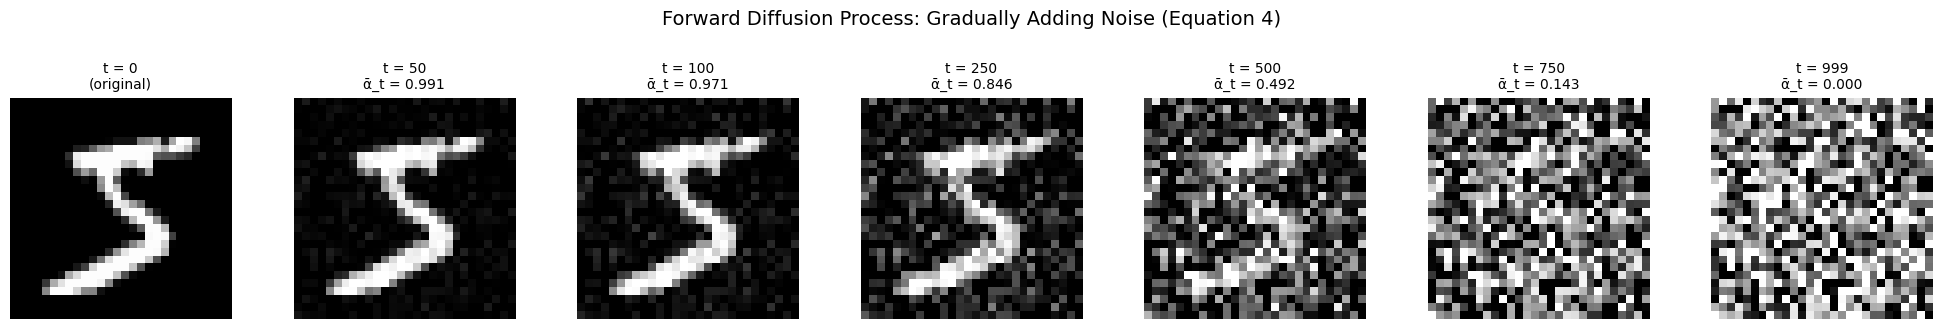


📊 Observations:
  t=0: Clean image (ᾱ_0 = 1.000)
  t=50: Slightly noisy (ᾱ_50 = 0.992)
  t=500: Very noisy (ᾱ_500 = 0.494)
  t=999: Pure noise (ᾱ_999 = 0.000)

  ✓ As t increases, signal √ᾱ_t → 0 and noise √(1-ᾱ_t) → 1
  ✓ By t=999, the image is indistinguishable from Gaussian noise!


In [7]:
def visualize_forward_diffusion(diffusion, x_start, timesteps_to_show=[0, 50, 100, 250, 500, 750, 999]):
    """
    Visualize the forward diffusion process at different timesteps.
    
    Args:
        diffusion: GaussianDiffusion instance
        x_start: Clean image, shape (1, C, H, W)
        timesteps_to_show: List of timesteps to visualize
    """
    # Use the same noise for all timesteps (for consistent visualization)
    noise = torch.randn_like(x_start)
    
    fig, axes = plt.subplots(1, len(timesteps_to_show), figsize=(20, 3))
    
    for idx, t in enumerate(timesteps_to_show):
        # Create timestep tensor
        t_tensor = torch.tensor([t], device=x_start.device)
        
        if t == 0:
            # Original image
            x_t = x_start
        else:
            # Apply forward diffusion (Equation 4)
            x_t = diffusion.q_sample(x_start, t_tensor, noise=noise)
        
        # Convert to numpy and denormalize
        img = x_t.cpu().squeeze().numpy()
        img = (img + 1) / 2  # Scale from [-1, 1] to [0, 1]
        img = np.clip(img, 0, 1)
        
        # Plot
        axes[idx].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[idx].set_title(f't = {t}\nᾱ_t = {diffusion.alphas_cumprod[t]:.3f}' if t > 0 else 't = 0\n(original)',
                           fontsize=10)
        axes[idx].axis('off')
    
    plt.suptitle('Forward Diffusion Process: Gradually Adding Noise (Equation 4)', fontsize=14, y=1.08)
    plt.tight_layout()
    plt.savefig('../outputs/forward_diffusion.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n📊 Observations:")
    print(f"  t=0: Clean image (ᾱ_0 = 1.000)")
    print(f"  t=50: Slightly noisy (ᾱ_50 = {diffusion.alphas_cumprod[49]:.3f})")
    print(f"  t=500: Very noisy (ᾱ_500 = {diffusion.alphas_cumprod[499]:.3f})")
    print(f"  t=999: Pure noise (ᾱ_999 = {diffusion.alphas_cumprod[999]:.3f})")
    print(f"\n  ✓ As t increases, signal √ᾱ_t → 0 and noise √(1-ᾱ_t) → 1")
    print(f"  ✓ By t=999, the image is indistinguishable from Gaussian noise!")

# Visualize!
visualize_forward_diffusion(diffusion, sample_image)


---

# 5. UNet Architecture

## 5.1 Why UNet for Diffusion Models?

The neural network $\epsilon_\theta(x_t, t)$ needs to:
1. Take noisy image $x_t$ as input
2. Take timestep $t$ as input (to know how much noise there is)
3. Predict the noise $\epsilon$ that was added

**UNet** is perfect because:
- **Encoder-decoder structure**: Captures multi-scale features
- **Skip connections**: Preserves spatial information
- **Time conditioning**: Can inject timestep information at multiple scales

### Architecture Overview

```
Time t → [Sinusoidal Embedding] → [MLP] → time_emb
                                              ↓
Input x_t (28×28) → [Conv] → [ResBlock + time_emb] → 28×28
                                ↓
                          [Downsample] → 14×14
                          [ResBlock + time_emb]
                                ↓
                          [Downsample] → 7×7
                          [ResBlock + time_emb]
                          [Attention]  (bottleneck)
                                ↓
                          [Upsample] → 14×14
                          [ResBlock + time_emb + skip]
                                ↓
                          [Upsample] → 28×28
                          [ResBlock + time_emb + skip]
                                ↓
                          [Conv] → predicted noise
```

We'll build this bottom-up, starting with the building blocks.

## 5.2 Building Block 1: Sinusoidal Position Embeddings

We need to encode timestep $t$ into a continuous embedding. We use **sinusoidal embeddings** (same as Transformer positional encoding):

$$
\text{PE}(t, 2i) = \sin\left(\frac{t}{10000^{2i/d}}\right)
$$
$$
\text{PE}(t, 2i+1) = \cos\left(\frac{t}{10000^{2i/d}}\right)
$$

where $d$ is the embedding dimension and $i$ is the position within the embedding.

**Why sinusoidal?** Different frequencies allow the model to easily learn to attend to different noise levels.

In [8]:
class SinusoidalPositionEmbeddings(nn.Module):
    """
    Sinusoidal position embeddings for timesteps.
    Same as used in Transformers (Vaswani et al., 2017)
    
    Maps timestep t to a high-dimensional embedding using sin/cos functions.
    """
    
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, time):
        """
        Args:
            time: Tensor of shape (batch_size,) containing timesteps
        
        Returns:
            embeddings: Tensor of shape (batch_size, dim)
        """
        device = time.device
        half_dim = self.dim // 2
        
        # Compute frequencies: 1 / 10000^(2i/d)
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        
        # Outer product: (batch_size, 1) * (1, half_dim) = (batch_size, half_dim)
        embeddings = time[:, None] * embeddings[None, :]
        
        # Apply sin and cos, then concatenate
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        
        return embeddings

# Test the embeddings
time_dim = 128
time_emb = SinusoidalPositionEmbeddings(time_dim)

# Test with a few timesteps
test_times = torch.tensor([0, 100, 500, 999], device=device)
test_embeddings = time_emb(test_times)

print(f"✓ Sinusoidal embeddings:")
print(f"  Input shape: {test_times.shape}")
print(f"  Output shape: {test_embeddings.shape}")
print(f"  Embedding range: [{test_embeddings.min():.3f}, {test_embeddings.max():.3f}]")
print(f"  Different timesteps have different embeddings ✓")


✓ Sinusoidal embeddings:
  Input shape: torch.Size([4])
  Output shape: torch.Size([4, 128])
  Embedding range: [-1.000, 1.000]
  Different timesteps have different embeddings ✓


## 5.3 Building Block 2: Residual Block with Time Conditioning

A residual block processes the image features and injects time information:

```
x → [GroupNorm] → [SiLU] → [Conv 3×3]
                                ↓
time_emb → [Linear] ──────────→ [Add]
                                ↓
          [GroupNorm] → [SiLU] → [Dropout] → [Conv 3×3]
                                                  ↓
x ─────────────────────────────────────────────→ [Add] → output
```

**Key components**:
- **GroupNorm**: Normalizes features (8 groups by default, better than BatchNorm for small batches)
- **SiLU** (Swish): $\text{SiLU}(x) = x \cdot \sigma(x)$, smooth activation function
- **Time injection**: Add time embedding after first convolution
- **Residual connection**: Add input to output for better gradient flow

In [9]:
class ResidualBlock(nn.Module):
    """
    Residual block with time embedding injection.
    
    Architecture:
    x → GroupNorm → SiLU → Conv → (+time_emb) → GroupNorm → SiLU → Dropout → Conv → (+residual)
    """
    
    def __init__(self, in_channels, out_channels, time_emb_dim, dropout=0.1):
        super().__init__()
        
        # First convolution block
        self.norm1 = nn.GroupNorm(8, in_channels)  # 8 groups
        self.act1 = nn.SiLU()  # Swish activation
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        
        # Time embedding projection
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )
        
        # Second convolution block
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.act2 = nn.SiLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
        # Residual connection (if channel dimensions don't match, use 1×1 conv)
        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.residual_conv = nn.Identity()
    
    def forward(self, x, time_emb):
        """
        Args:
            x: Image features, shape (B, C, H, W)
            time_emb: Time embeddings, shape (B, time_emb_dim)
        
        Returns:
            output: Processed features, shape (B, out_channels, H, W)
        """
        # Save for residual connection
        residual = self.residual_conv(x)
        
        # First conv block
        h = self.norm1(x)
        h = self.act1(h)
        h = self.conv1(h)
        
        # Add time embedding: (B, C) → (B, C, 1, 1) for broadcasting
        time_emb = self.time_mlp(time_emb)
        h = h + time_emb[:, :, None, None]
        
        # Second conv block
        h = self.norm2(h)
        h = self.act2(h)
        h = self.dropout(h)
        h = self.conv2(h)
        
        # Add residual
        return h + residual

# Test the residual block
res_block = ResidualBlock(64, 128, time_dim).to(device)
test_x = torch.randn(4, 64, 28, 28, device=device)
test_t_emb = torch.randn(4, time_dim, device=device)
test_out = res_block(test_x, test_t_emb)

print(f"\n✓ ResidualBlock:")
print(f"  Input: {test_x.shape}")
print(f"  Time emb: {test_t_emb.shape}")
print(f"  Output: {test_out.shape}")
print(f"  Time information successfully injected ✓")



✓ ResidualBlock:
  Input: torch.Size([4, 64, 28, 28])
  Time emb: torch.Size([4, 128])
  Output: torch.Size([4, 128, 28, 28])
  Time information successfully injected ✓


## 5.4 Building Block 3: Self-Attention Block

Attention allows the model to capture long-range dependencies in the image.

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V
$$

For images, we flatten spatial dimensions:
- Input: $(B, C, H, W)$
- Reshape to: $(B, H \times W, C)$ (treat spatial positions as sequence)
- Apply multi-head attention
- Reshape back to: $(B, C, H, W)$

**Why attention?** At low resolutions (e.g., 7×7), global attention helps the model understand the entire image structure.

In [10]:
class AttentionBlock(nn.Module):
    """
    Self-attention block for capturing long-range dependencies.
    Uses multi-head attention on flattened spatial dimensions.
    """
    
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        
        assert channels % num_heads == 0, f"channels={channels} must be divisible by num_heads={num_heads}"
        
        self.norm = nn.GroupNorm(8, channels)
        self.attention = nn.MultiheadAttention(channels, num_heads, batch_first=True)
    
    def forward(self, x):
        """
        Args:
            x: Image features, shape (B, C, H, W)
        
        Returns:
            output: Attention-processed features, shape (B, C, H, W)
        """
        B, C, H, W = x.shape
        
        # Save for residual
        residual = x
        
        # Normalize
        x = self.norm(x)
        
        # Reshape: (B, C, H, W) → (B, H*W, C)
        x = x.view(B, C, H * W).transpose(1, 2)
        
        # Self-attention (Q=K=V)
        x, _ = self.attention(x, x, x, need_weights=False)
        
        # Reshape back: (B, H*W, C) → (B, C, H, W)
        x = x.transpose(1, 2).view(B, C, H, W)
        
        # Add residual
        return x + residual

# Test attention block
attn_block = AttentionBlock(128, num_heads=4).to(device)
test_x = torch.randn(4, 128, 7, 7, device=device)
test_out = attn_block(test_x)

print(f"\n✓ AttentionBlock:")
print(f"  Input: {test_x.shape}")
print(f"  Output: {test_out.shape}")
print(f"  Attention over {7*7} spatial positions")
print(f"  Long-range dependencies captured ✓")



✓ AttentionBlock:
  Input: torch.Size([4, 128, 7, 7])
  Output: torch.Size([4, 128, 7, 7])
  Attention over 49 spatial positions
  Long-range dependencies captured ✓


## 5.5 Complete UNet Assembly

Now let's assemble all building blocks into a complete UNet.

**Architecture for MNIST (28×28)**:
1. **Initial conv**: 1 → 64 channels
2. **Encoder**:
   - Level 0: 64 channels, 28×28
   - Level 1: 128 channels, 14×14
   - Level 2: 256 channels, 7×7 (with attention)
3. **Bottleneck**: 256 channels, 7×7 (ResBlock + Attention + ResBlock)
4. **Decoder** (with skip connections):
   - Level 2: 256 channels, 7×7
   - Level 1: 128 channels, 14×14
   - Level 0: 64 channels, 28×28
5. **Output conv**: 64 → 1 channel (predicted noise)

**Skip connections**: Encoder features are concatenated with decoder features at matching resolutions.

In [11]:
class SimpleUNet(nn.Module):
    """
    Simple UNet for DDPM on MNIST 28×28 images.
    
    Input: noisy image x_t and timestep t
    Output: predicted noise ε_θ(x_t, t)
    """
    
    def __init__(
        self,
        in_channels=1,
        out_channels=1,
        base_channels=64,
        channel_mult=(1, 2, 4),
        time_emb_dim=128,
        num_res_blocks=2,
        attention_resolutions=(7,),  # Apply attention at 7×7 resolution
        dropout=0.1
    ):
        super().__init__()
        
        self.in_channels = in_channels
        self.time_emb_dim = time_emb_dim
        
        # ====================================================================
        # Time embedding MLP
        # ====================================================================
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )
        
        # ====================================================================
        # Initial convolution
        # ====================================================================
        self.conv_in = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)
        
        # Calculate channel dimensions for each level
        channels = [base_channels * mult for mult in channel_mult]
        
        # ====================================================================
        # Encoder (downsampling)
        # ====================================================================
        self.encoder = nn.ModuleList()
        self.encoder_downs = nn.ModuleList()
        
        in_ch = base_channels
        resolution = 28  # MNIST size
        
        for level, out_ch in enumerate(channels):
            # Residual blocks for this level
            blocks = nn.ModuleList()
            for _ in range(num_res_blocks):
                blocks.append(ResidualBlock(in_ch, out_ch, time_emb_dim, dropout))
                in_ch = out_ch
            
            # Add attention if at specified resolution
            if resolution in attention_resolutions:
                blocks.append(AttentionBlock(out_ch))
            
            self.encoder.append(blocks)
            
            # Downsample (except at last level)
            if level < len(channels) - 1:
                self.encoder_downs.append(nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=2, padding=1))
                resolution //= 2
        
        # ====================================================================
        # Bottleneck (middle)
        # ====================================================================
        mid_ch = channels[-1]
        self.middle = nn.ModuleList([
            ResidualBlock(mid_ch, mid_ch, time_emb_dim, dropout),
            AttentionBlock(mid_ch),
            ResidualBlock(mid_ch, mid_ch, time_emb_dim, dropout)
        ])
        
        # ====================================================================
        # Decoder (upsampling)
        # ====================================================================
        self.decoder = nn.ModuleList()
        self.decoder_ups = nn.ModuleList()
        
        in_ch = mid_ch
        
        for level, out_ch in enumerate(reversed(channels)):
            # Residual blocks for this level
            blocks = nn.ModuleList()
            for i in range(num_res_blocks + 1):  # +1 for skip connection
                # First block receives skip connection
                skip_ch = out_ch if i == 0 else 0
                blocks.append(ResidualBlock(in_ch + skip_ch, out_ch, time_emb_dim, dropout))
                in_ch = out_ch
            
            # Add attention if at specified resolution
            if resolution in attention_resolutions:
                blocks.append(AttentionBlock(out_ch))
            
            self.decoder.append(blocks)
            
            # Upsample (except at last level)
            if level < len(channels) - 1:
                self.decoder_ups.append(nn.ConvTranspose2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1))
                resolution *= 2
        
        # ====================================================================
        # Output convolution
        # ====================================================================
        self.conv_out = nn.Sequential(
            nn.GroupNorm(8, base_channels),
            nn.SiLU(),
            nn.Conv2d(base_channels, out_channels, kernel_size=3, padding=1)
        )
    
    def forward(self, x, time):
        """
        Args:
            x: Noisy images, shape (B, C, H, W)
            time: Timesteps, shape (B,)
        
        Returns:
            predicted_noise: Predicted noise ε_θ(x_t, t), shape (B, C, H, W)
        """
        # Get time embeddings
        t_emb = self.time_mlp(time)
        
        # Initial convolution
        h = self.conv_in(x)
        
        # Encoder
        encoder_outputs = [h]
        for level, blocks in enumerate(self.encoder):
            for block in blocks:
                if isinstance(block, ResidualBlock):
                    h = block(h, t_emb)
                else:  # AttentionBlock
                    h = block(h)
            
            encoder_outputs.append(h)
            
            # Downsample
            if level < len(self.encoder_downs):
                h = self.encoder_downs[level](h)
        
        # Bottleneck
        for block in self.middle:
            if isinstance(block, ResidualBlock):
                h = block(h, t_emb)
            else:  # AttentionBlock
                h = block(h)
        
        # Decoder
        for level, blocks in enumerate(self.decoder):
            # Get skip connection from encoder
            skip = encoder_outputs.pop()
            
            for i, block in enumerate(blocks):
                if isinstance(block, ResidualBlock):
                    # Add skip connection to first block
                    if i == 0:
                        h = torch.cat([h, skip], dim=1)
                    h = block(h, t_emb)
                else:  # AttentionBlock
                    h = block(h)
            
            # Upsample
            if level < len(self.decoder_ups):
                h = self.decoder_ups[level](h)
        
        # Output
        return self.conv_out(h)

# ============================================================================
# Create and test the UNet
# ============================================================================

model = SimpleUNet(
    in_channels=1,
    out_channels=1,
    base_channels=64,
    channel_mult=(1, 2, 4),
    time_emb_dim=128,
    attention_resolutions=(7,)
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✅ UNet created successfully!")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB (FP32)")

# Test forward pass
test_batch = 8
test_x = torch.randn(test_batch, 1, 28, 28, device=device)
test_t = torch.randint(0, 1000, (test_batch,), device=device)

with torch.no_grad():
    test_output = model(test_x, test_t)

print(f"\n✓ Forward pass successful:")
print(f"  Input shape: {test_x.shape}")
print(f"  Time shape: {test_t.shape}")
print(f"  Output shape: {test_output.shape}")
print(f"  ✓ Output shape matches input shape!")
print(f"\n🎉 UNet is ready to predict noise ε_θ(x_t, t)!")



✅ UNet created successfully!
  Total parameters: 13,716,993
  Trainable parameters: 13,716,993
  Model size: ~52.3 MB (FP32)

✓ Forward pass successful:
  Input shape: torch.Size([8, 1, 28, 28])
  Time shape: torch.Size([8])
  Output shape: torch.Size([8, 1, 28, 28])
  ✓ Output shape matches input shape!

🎉 UNet is ready to predict noise ε_θ(x_t, t)!


## 6.1 Training Algorithm from the DDPM Paper

### Why This Specific Loss Function?

In Section 2.4, we derived the full training objective (Equation 5):

$$
L = D_{KL}(q(x_T|x_0) \| p(x_T)) + \sum_{t=2}^{T} D_{KL}(q(x_{t-1}|x_t,x_0) \| p_\theta(x_{t-1}|x_t)) - \log p_\theta(x_0|x_1)
$$

This is mathematically correct, but **the DDPM paper found something better!**

### From Complex ELBO to Simple MSE

The authors discovered that instead of optimizing the full ELBO with all those KL divergence terms, we can use a much simpler objective:

$$
\boxed{L_{\text{simple}} = \mathbb{E}_{t, x_0, \epsilon} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]}
$$

**Paper Equation (14)** - This is just MSE (Mean Squared Error) between true and predicted noise!

### Why Does This Work? (From the Paper)

#### 1. **Connection to the Full Objective**

The KL divergence term $D_{KL}(q(x_{t-1}|x_t,x_0) \| p_\theta(x_{t-1}|x_t))$ can be expanded. Since both are Gaussians:

$$
D_{KL}(q \| p_\theta) \propto \mathbb{E}_{x_0, \epsilon} \left[ \frac{1}{2\sigma_t^2} \| \tilde{\mu}_t(x_t, x_0) - \mu_\theta(x_t, t) \|^2 \right]
$$

where $\tilde{\mu}_t$ is the true posterior mean (Equation 7) and $\mu_\theta$ is our predicted mean (Equation 11).

#### 2. **Reparameterization in Terms of Noise**

From Equation (11), we know:

$$
\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right)
$$

Similarly, the true mean $\tilde{\mu}_t$ can be expressed using the **true noise** $\epsilon$:

$$
\tilde{\mu}_t(x_t, x_0) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon \right)
$$

#### 3. **Simplification**

The difference between these means is:

$$
\| \tilde{\mu}_t - \mu_\theta \|^2 = \left\| \frac{1}{\sqrt{\alpha_t}} \cdot \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} (\epsilon - \epsilon_\theta) \right\|^2
$$

The coefficients $\frac{1}{\sqrt{\alpha_t}}$ and $\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}$ are just constants (for a given $t$). So minimizing this is equivalent to minimizing:

$$
\| \epsilon - \epsilon_\theta(x_t, t) \|^2
$$

**This is just predicting the noise!**

#### 4. **Removing the Weighting (Key Paper Finding!)**

The full objective has a time-dependent weighting:

$$
L_{t-1} = \mathbb{E}_{x_0, \epsilon} \left[ \frac{(1-\alpha_t)^2}{2\sigma_t^2 \alpha_t (1-\bar{\alpha}_t)} \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]
$$

The DDPM authors **empirically found** (Table 1 in paper) that:
- Removing this complicated weighting works **better** in practice!
- The simplified loss $L_{\text{simple}}$ without weighting leads to higher quality samples
- This is similar to how unweighted MSE works better than weighted versions in many tasks

### Algorithm 1: Simplified Training (From DDPM Paper)

```
repeat
    1. Sample x_0 ~ q(x_0)              # Get a real image from dataset
    2. Sample t ~ Uniform({1,...,T})    # Pick a random noise level
    3. Sample ε ~ N(0, I)                # Sample random Gaussian noise
    4. Take gradient descent step on:
       ∇_θ ||ε - ε_θ(√ᾱ_t·x_0 + √(1-ᾱ_t)·ε, t)||^2
       
       ↑ This is Equation (4): forward process
       ↑ x_t = √ᾱ_t·x_0 + √(1-ᾱ_t)·ε
until converged
```

### Why This Loss Makes Intuitive Sense

**The model is learning**:
1. Given a noisy image $x_t$ (with unknown noise level $t$)
2. Predict what noise $\epsilon$ was added to get here
3. If we know the noise, we can remove it! (Equation 11)

**Analogy**: It's like:
- Someone shows you a photo with scratches
- You learn to identify what the scratches look like
- Then you can remove them to see the original photo

### Translation to Code

The algorithm translates to:

```python
# 1. Get real image
x_0 = batch_from_dataset

# 2. Random timestep
t = random.randint(0, T)

# 3. Random noise
epsilon = torch.randn_like(x_0)

# 4. Forward process (Equation 4)
x_t = sqrt(alpha_bar[t]) * x_0 + sqrt(1 - alpha_bar[t]) * epsilon

# 5. Predict noise
epsilon_predicted = model(x_t, t)

# 6. Compute loss (Equation 14)
loss = MSE(epsilon, epsilon_predicted)

# 7. Backprop
loss.backward()
```

**That's it!** No complex KL divergences, no variance estimation, just simple noise prediction.

### Key Insight from the Paper

> *"We found that training with $L_{\text{simple}}$ (ignoring the weighting) resulted in better sample quality than training with the full $L$ objective."* 
> — Ho et al., DDPM (2020)

This is a common pattern in deep learning: **simpler objectives often work better** than theoretically motivated complex ones!


## 6.2 Dataset Preparation

We already loaded MNIST earlier. Now let's split it into train/validation sets and create DataLoaders.

In [12]:
# ============================================================================
# Split dataset into train and validation
# ============================================================================

train_size = int(0.9 * len(dataset))  # 90% for training
val_size = len(dataset) - train_size  # 10% for validation

train_dataset, val_dataset = random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"✓ Dataset split:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")

# ============================================================================
# Create DataLoaders
# ============================================================================

BATCH_SIZE = 128
NUM_WORKERS = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\n✓ DataLoaders created:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")


✓ Dataset split:
  Training samples: 54000
  Validation samples: 6000

✓ DataLoaders created:
  Batch size: 128
  Training batches: 422
  Validation batches: 47


## 6.3 Training Configuration

Let's set up all hyperparameters for training.

In [13]:
# ============================================================================
# Hyperparameters
# ============================================================================

EPOCHS = 20
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 0.0

# Mixed precision training (faster, uses less memory)
USE_MIXED_PRECISION = torch.cuda.is_available()

# Checkpointing
SAVE_EVERY = 5  # Save checkpoint every N epochs
GENERATE_SAMPLES_EVERY = 5  # Generate samples every N epochs

# Early stopping
PATIENCE = 5  # Stop if validation loss doesn't improve for N epochs

print(f"✓ Training configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Mixed precision: {USE_MIXED_PRECISION}")
print(f"  Device: {device}")

# ============================================================================
# Optimizer and Scheduler
# ============================================================================

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Cosine annealing learning rate schedule
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
    eta_min=LEARNING_RATE / 10
)

# Mixed precision scaler
scaler = GradScaler() if USE_MIXED_PRECISION else None

print(f"\n✓ Optimizer: AdamW")
print(f"✓ Scheduler: CosineAnnealingLR")
print(f"✓ Gradient scaler: {'Enabled' if USE_MIXED_PRECISION else 'Disabled'}")


✓ Training configuration:
  Epochs: 20
  Learning rate: 0.0002
  Batch size: 128
  Mixed precision: True
  Device: cuda

✓ Optimizer: AdamW
✓ Scheduler: CosineAnnealingLR
✓ Gradient scaler: Enabled


## 6.4 Training Loop

Now let's implement the complete training loop with:
- Loss tracking (train & validation)
- Model checkpointing
- Sample generation during training
- Early stopping
- Progress bars

In [14]:
def train_one_epoch(model, diffusion, train_loader, optimizer, scaler, device, epoch):
    """
    Train for one epoch.
    
    Implements Algorithm 1 from DDPM paper:
    L = E[||ε - ε_θ(x_t, t)||^2]
    """
    model.train()
    total_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    
    for batch_idx, (images, _) in enumerate(pbar):
        images = images.to(device)
        batch_size = images.shape[0]
        
        # ====================================================================
        # Algorithm 1 from DDPM paper
        # ====================================================================
        
        # 1. Sample t ~ Uniform({1,...,T})
        t = torch.randint(0, diffusion.timesteps, (batch_size,), device=device).long()
        
        # 2. Sample ε ~ N(0, I)
        noise = torch.randn_like(images)
        
        # 3. Get noisy images: x_t = √ᾱ_t·x_0 + √(1-ᾱ_t)·ε (Equation 4)
        x_noisy = diffusion.q_sample(images, t, noise=noise)
        
        # 4. Predict noise with model
        with autocast(enabled=USE_MIXED_PRECISION):
            predicted_noise = model(x_noisy, t)
            
            # 5. Compute loss: ||ε - ε_θ(x_t, t)||^2 (Equation 14)
            loss = F.mse_loss(predicted_noise, noise)
        
        # 6. Backpropagation
        optimizer.zero_grad()
        
        if USE_MIXED_PRECISION:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        
        # Track loss
        total_loss += loss.item()
        
        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss


@torch.no_grad()
def validate(model, diffusion, val_loader, device):
    """
    Validate the model.
    """
    model.eval()
    total_loss = 0.0
    
    for images, _ in val_loader:
        images = images.to(device)
        batch_size = images.shape[0]
        
        # Sample random timesteps
        t = torch.randint(0, diffusion.timesteps, (batch_size,), device=device).long()
        
        # Add noise
        noise = torch.randn_like(images)
        x_noisy = diffusion.q_sample(images, t, noise=noise)
        
        # Predict noise
        predicted_noise = model(x_noisy, t)
        
        # Compute loss
        loss = F.mse_loss(predicted_noise, noise)
        total_loss += loss.item()
    
    avg_loss = total_loss / len(val_loader)
    return avg_loss


def save_checkpoint(model, optimizer, scheduler, epoch, train_loss, val_loss, filename):
    """
    Save model checkpoint.
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss
    }
    torch.save(checkpoint, filename)
    print(f"  ✓ Checkpoint saved: {filename}")


print("✅ Training functions defined!")


✅ Training functions defined!


## 6.5 Main Training Loop

Let's train the model!

In [15]:
# ============================================================================
# Training loop
# ============================================================================

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

for epoch in range(EPOCHS):
    # Train
    train_loss = train_one_epoch(model, diffusion, train_loader, optimizer, scaler, device, epoch)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate(model, diffusion, val_loader, device)
    val_losses.append(val_loss)
    
    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{EPOCHS}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  LR: {current_lr:.6f}")
    
    # Save checkpoint periodically
    if (epoch + 1) % SAVE_EVERY == 0:
        checkpoint_path = f"{checkpoint_dir}/ddpm_mnist_epoch_{epoch+1}.pt"
        save_checkpoint(model, optimizer, scheduler, epoch, train_loss, val_loss, checkpoint_path)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_checkpoint_path = f"{checkpoint_dir}/ddpm_mnist_best.pt"
        save_checkpoint(model, optimizer, scheduler, epoch, train_loss, val_loss, best_checkpoint_path)
        print(f"  🎉 New best validation loss: {val_loss:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs")
        print(f"  No improvement for {PATIENCE} epochs")
        break
    
    # Generate samples periodically (we'll implement this next)
    # if (epoch + 1) % GENERATE_SAMPLES_EVERY == 0:
    #     generate_and_save_samples(model, diffusion, epoch)

print("\n" + "="*70)
print("TRAINING COMPLETED!")
print("="*70)
print(f"\n✅ Final Results:")
print(f"  Best validation loss: {best_val_loss:.4f}")
print(f"  Total epochs: {len(train_losses)}")



STARTING TRAINING


Epoch 1/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]


Epoch 1/20:
  Train Loss: 0.1137
  Val Loss:   0.0582
  LR: 0.000199
  ✓ Checkpoint saved: ../checkpoints/ddpm_mnist_best.pt
  🎉 New best validation loss: 0.0582


Epoch 2/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]


Epoch 2/20:
  Train Loss: 0.0593
  Val Loss:   0.0489
  LR: 0.000196
  ✓ Checkpoint saved: ../checkpoints/ddpm_mnist_best.pt
  🎉 New best validation loss: 0.0489


Epoch 3/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]


Epoch 3/20:
  Train Loss: 0.0514
  Val Loss:   0.0440
  LR: 0.000190
  ✓ Checkpoint saved: ../checkpoints/ddpm_mnist_best.pt
  🎉 New best validation loss: 0.0440


Epoch 4/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]


Epoch 4/20:
  Train Loss: 0.0473
  Val Loss:   0.0435
  LR: 0.000183
  ✓ Checkpoint saved: ../checkpoints/ddpm_mnist_best.pt
  🎉 New best validation loss: 0.0435


Epoch 5/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out



Epoch 5/20:
  Train Loss: 0.0459
  Val Loss:   0.0410
  LR: 0.000174
  ✓ Checkpoint saved: ../checkpoints/ddpm_mnist_epoch_5.pt
  ✓ Checkpoint saved: ../checkpoints/ddpm_mnist_best.pt
  🎉 New best validation loss: 0.0410


Epoch 6/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]


Epoch 6/20:
  Train Loss: 0.0437
  Val Loss:   0.0411
  LR: 0.000163


Epoch 7/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]


Epoch 7/20:
  Train Loss: 0.0432
  Val Loss:   0.0398
  LR: 0.000151
  ✓ Checkpoint saved: ../checkpoints/ddpm_mnist_best.pt
  🎉 New best validation loss: 0.0398


Epoch 8/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]


Epoch 8/20:
  Train Loss: 0.0418
  Val Loss:   0.0397
  LR: 0.000138
  ✓ Checkpoint saved: ../checkpoints/ddpm_mnist_best.pt
  🎉 New best validation loss: 0.0397


Epoch 9/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdfdddec5e0>
Traceback (most recent call last):
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdfdddec5e0>
Traceback (most recent call last):
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/oncreative/anaconda3/en


Epoch 9/20:
  Train Loss: 0.0414
  Val Loss:   0.0392
  LR: 0.000124
  ✓ Checkpoint saved: ../checkpoints/ddpm_mnist_best.pt
  🎉 New best validation loss: 0.0392


Epoch 10/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]


Epoch 10/20:
  Train Loss: 0.0409
  Val Loss:   0.0390
  LR: 0.000110
  ✓ Checkpoint saved: ../checkpoints/ddpm_mnist_epoch_10.pt
  ✓ Checkpoint saved: ../checkpoints/ddpm_mnist_best.pt
  🎉 New best validation loss: 0.0390


Epoch 11/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]


Epoch 11/20:
  Train Loss: 0.0406
  Val Loss:   0.0378
  LR: 0.000096
  ✓ Checkpoint saved: ../checkpoints/ddpm_mnist_best.pt
  🎉 New best validation loss: 0.0378


Epoch 12/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]


Epoch 12/20:
  Train Loss: 0.0401
  Val Loss:   0.0381
  LR: 0.000082


Epoch 13/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]


Epoch 13/20:
  Train Loss: 0.0394
  Val Loss:   0.0381
  LR: 0.000069


Epoch 14/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdfdddec5e0>
Traceback (most recent call last):
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdfdddec5e0>
Traceback (most recent call last):
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/oncreative/anaconda3/en


Epoch 14/20:
  Train Loss: 0.0392
  Val Loss:   0.0387
  LR: 0.000057


Epoch 15/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]


Epoch 15/20:
  Train Loss: 0.0389
  Val Loss:   0.0367
  LR: 0.000046
  ✓ Checkpoint saved: ../checkpoints/ddpm_mnist_epoch_15.pt
  ✓ Checkpoint saved: ../checkpoints/ddpm_mnist_best.pt
  🎉 New best validation loss: 0.0367


Epoch 16/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]


Epoch 16/20:
  Train Loss: 0.0389
  Val Loss:   0.0374
  LR: 0.000037


Epoch 17/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]


Epoch 17/20:
  Train Loss: 0.0389
  Val Loss:   0.0373
  LR: 0.000030


Epoch 18/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]


Epoch 18/20:
  Train Loss: 0.0383
  Val Loss:   0.0364
  LR: 0.000024
  ✓ Checkpoint saved: ../checkpoints/ddpm_mnist_best.pt
  🎉 New best validation loss: 0.0364


Epoch 19/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]


Epoch 19/20:
  Train Loss: 0.0381
  Val Loss:   0.0362
  LR: 0.000021
  ✓ Checkpoint saved: ../checkpoints/ddpm_mnist_best.pt
  🎉 New best validation loss: 0.0362


Epoch 20/20 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdfdddec5e0>
Traceback (most recent call last):
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdfdddec5e0>
Traceback (most recent call last):
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/oncreative/anaconda3/en


Epoch 20/20:
  Train Loss: 0.0382
  Val Loss:   0.0370
  LR: 0.000020
  ✓ Checkpoint saved: ../checkpoints/ddpm_mnist_epoch_20.pt

TRAINING COMPLETED!

✅ Final Results:
  Best validation loss: 0.0362
  Total epochs: 20


## 6.6 Training Loss Visualization

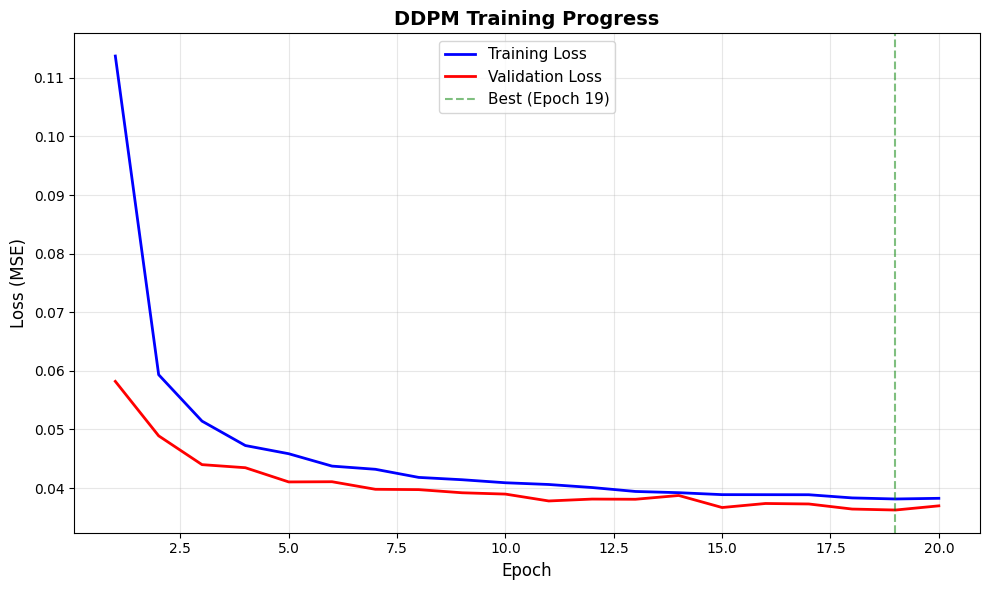


✓ Training curves saved to outputs/training_loss.png

📊 Training Statistics:
  Initial train loss: 0.1137
  Final train loss: 0.0382
  Improvement: 66.4%

  Best val loss: 0.0362 (Epoch 19)


In [16]:
# ============================================================================
# Plot training and validation losses
# ============================================================================

plt.figure(figsize=(10, 6))
epochs_range = range(1, len(train_losses) + 1)

plt.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('DDPM Training Progress', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Mark best epoch
best_epoch = val_losses.index(min(val_losses)) + 1
plt.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5, label=f'Best (Epoch {best_epoch})')
plt.legend(fontsize=11)

plt.tight_layout()
plt.savefig('../outputs/training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Training curves saved to outputs/training_loss.png")
print(f"\n📊 Training Statistics:")
print(f"  Initial train loss: {train_losses[0]:.4f}")
print(f"  Final train loss: {train_losses[-1]:.4f}")
print(f"  Improvement: {(1 - train_losses[-1]/train_losses[0]) * 100:.1f}%")
print(f"\n  Best val loss: {best_val_loss:.4f} (Epoch {best_epoch})")


---

# 7. Sampling: Generating New Images

## 7.1 Sampling Algorithm from the DDPM Paper

**Algorithm 2** (Sampling) from the paper:

```
x_T ~ N(0, I)                          # Start from pure noise
for t = T, ..., 1 do:
    z ~ N(0, I) if t > 1, else z = 0   # Random noise (except last step)
    
    # Predict x_{t-1} from x_t
    x_{t-1} = 1/√α_t · (x_t - (1-α_t)/√(1-ᾱ_t) · ε_θ(x_t, t)) + σ_t · z
    
return x_0
```

**Translation**:
1. Start with pure random noise
2. For each timestep (from T down to 1):
   - Predict the noise at this level
   - Remove that noise (denoise one step)
   - Add a small amount of random noise (except at the very end)
3. After T steps, we get a clean image!

The reverse process implements **Equation (11)** from the paper.

## 7.2 Sampling Implementation

In [17]:
@torch.no_grad()
def ddpm_sample(model, diffusion, batch_size=16, image_size=28, channels=1, show_progress=True):
    """
    DDPM sampling algorithm (Algorithm 2 from paper).
    
    Generate images by reversing the diffusion process:
    Start from noise x_T and gradually denoise to get x_0.
    
    Args:
        model: Trained UNet model
        diffusion: GaussianDiffusion instance
        batch_size: Number of images to generate
        image_size: Image height/width
        channels: Number of channels (1 for grayscale)
        show_progress: Whether to show progress bar
    
    Returns:
        images: Generated images, shape (batch_size, channels, H, W)
    """
    model.eval()
    device = next(model.parameters()).device
    
    # ====================================================================
    # Start from pure Gaussian noise: x_T ~ N(0, I)
    # ====================================================================
    x = torch.randn(batch_size, channels, image_size, image_size, device=device)
    
    # ====================================================================
    # Reverse diffusion: T → T-1 → ... → 1 → 0
    # ====================================================================
    timesteps = list(range(diffusion.timesteps))[::-1]  # [T-1, T-2, ..., 1, 0]
    
    if show_progress:
        timesteps = tqdm(timesteps, desc="Generating samples")
    
    for t in timesteps:
        # Create timestep tensor
        t_tensor = torch.full((batch_size,), t, device=device, dtype=torch.long)
        
        # Predict noise: ε_θ(x_t, t)
        predicted_noise = model(x, t_tensor)
        
        # Get diffusion parameters for this timestep
        alpha_t = diffusion.alphas[t]
        alpha_bar_t = diffusion.alphas_cumprod[t]
        beta_t = diffusion.betas[t]
        
        # ====================================================================
        # Compute mean of p_θ(x_{t-1} | x_t) using Equation (11)
        # μ_θ = 1/√α_t · (x_t - (1-α_t)/√(1-ᾱ_t) · ε_θ(x_t, t))
        # ====================================================================
        mean = (1 / torch.sqrt(alpha_t)) * (
            x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * predicted_noise
        )
        
        if t > 0:
            # Add noise: z ~ N(0, I), scaled by σ_t
            noise = torch.randn_like(x)
            
            # Get variance (we use fixed variance from the paper)
            # σ_t^2 = β_t (simplified choice from paper)
            sigma_t = torch.sqrt(beta_t)
            
            # Sampling step: x_{t-1} = μ_θ + σ_t · z
            x = mean + sigma_t * noise
        else:
            # At t=0, don't add noise
            x = mean
    
    return x


def visualize_samples(samples, nrow=4, title="Generated Samples"):
    """
    Visualize generated samples in a grid.
    """
    # Denormalize from [-1, 1] to [0, 1]
    samples = (samples + 1) / 2
    samples = torch.clamp(samples, 0, 1)
    
    # Move to CPU and convert to grid
    samples = samples.cpu()
    
    # Create grid
    fig, axes = plt.subplots(nrow, nrow, figsize=(10, 10))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(samples):
            ax.imshow(samples[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return fig


print("✅ Sampling functions defined!")


✅ Sampling functions defined!


## 7.3 Load Best Model and Generate Samples

✓ Loaded best model from epoch 19
  Validation loss: 0.0362

🎨 Generating samples...


Generating samples:   0%|          | 0/1000 [00:00<?, ?it/s]

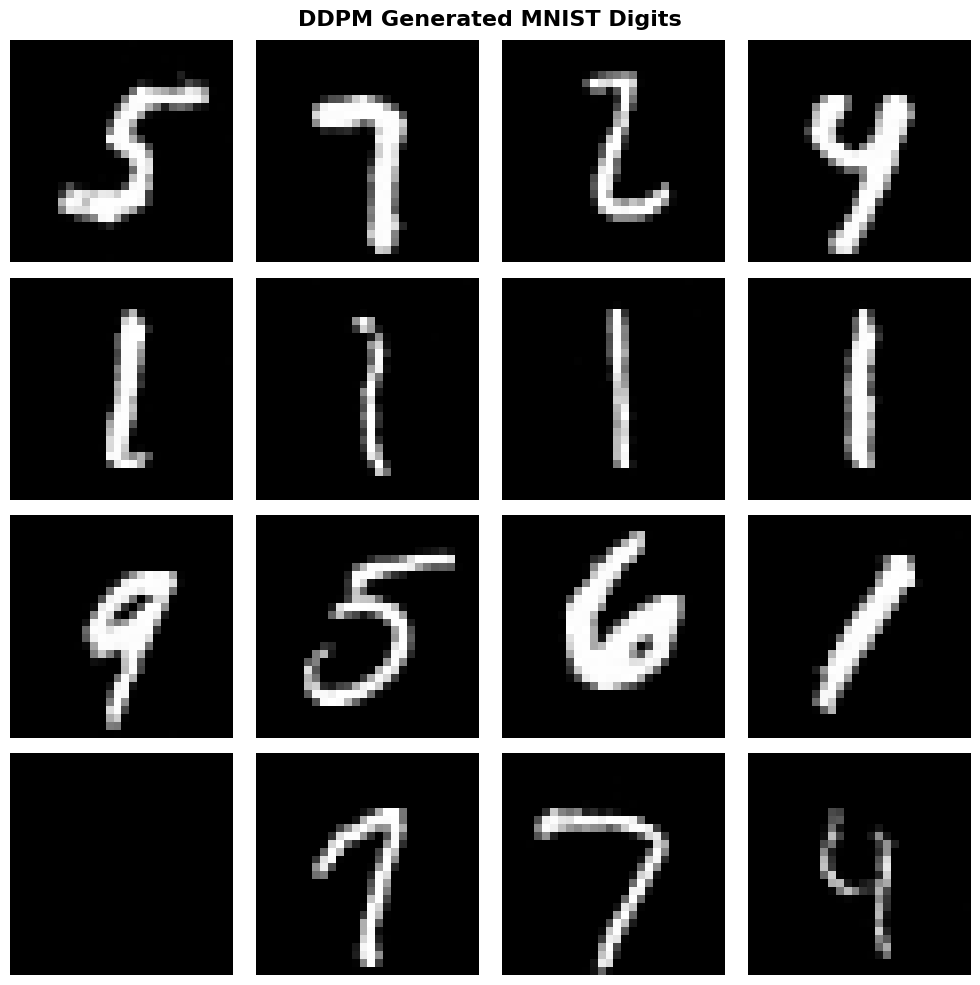


✅ Samples generated successfully!
  Generated 16 images
  Saved to outputs/generated_samples.png


In [18]:
# ============================================================================
# Load best checkpoint
# ============================================================================

best_checkpoint_path = f"{checkpoint_dir}/ddpm_mnist_best.pt"

if os.path.exists(best_checkpoint_path):
    checkpoint = torch.load(best_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Loaded best model from epoch {checkpoint['epoch'] + 1}")
    print(f"  Validation loss: {checkpoint['val_loss']:.4f}")
else:
    print("⚠️  No checkpoint found, using current model")

# ============================================================================
# Generate samples
# ============================================================================

print("\n🎨 Generating samples...")
samples = ddpm_sample(model, diffusion, batch_size=16, image_size=28, channels=1)

# Visualize
fig = visualize_samples(samples, nrow=4, title="DDPM Generated MNIST Digits")
plt.savefig('../outputs/generated_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Samples generated successfully!")
print(f"  Generated {len(samples)} images")
print(f"  Saved to outputs/generated_samples.png")


## 7.4 Visualize the Denoising Process

Let's visualize how a single image gradually emerges from noise.

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

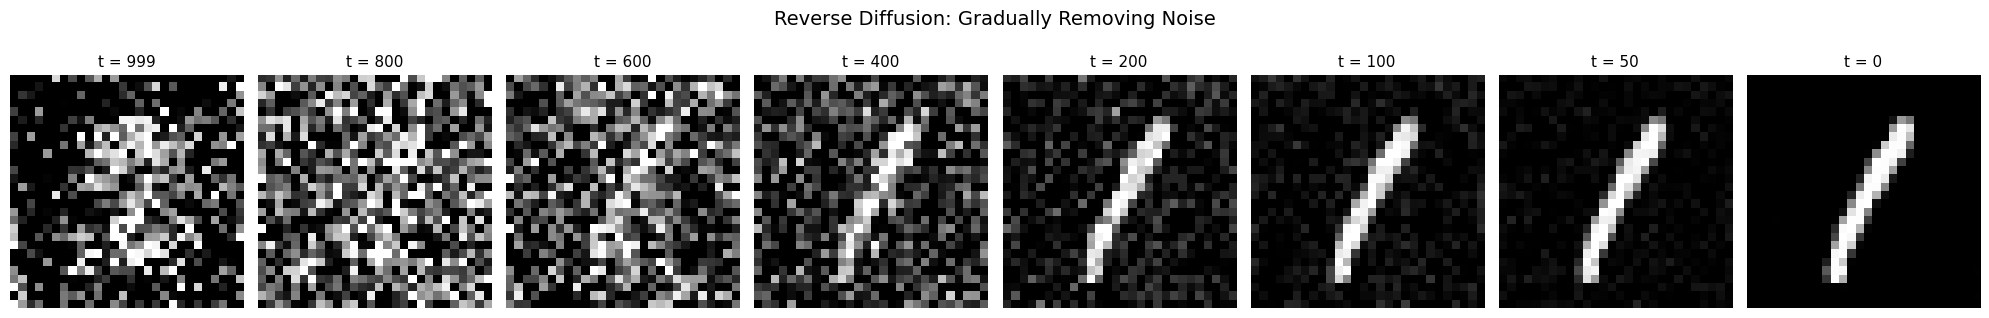


✅ Denoising process visualization complete!


In [19]:
@torch.no_grad()
def visualize_denoising_process(model, diffusion, steps_to_show=[999, 800, 600, 400, 200, 100, 50, 0]):
    """
    Visualize the denoising process at specific timesteps.
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Start from pure noise
    x = torch.randn(1, 1, 28, 28, device=device)
    
    # Store images at specific timesteps
    saved_images = []
    saved_timesteps = []
    
    # Reverse diffusion
    for t in tqdm(range(diffusion.timesteps - 1, -1, -1), desc="Denoising"):
        t_tensor = torch.tensor([t], device=device, dtype=torch.long)
        
        # Predict noise
        predicted_noise = model(x, t_tensor)
        
        # Get parameters
        alpha_t = diffusion.alphas[t]
        alpha_bar_t = diffusion.alphas_cumprod[t]
        beta_t = diffusion.betas[t]
        
        # Compute mean
        mean = (1 / torch.sqrt(alpha_t)) * (
            x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * predicted_noise
        )
        
        # Add noise (except at t=0)
        if t > 0:
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(beta_t)
            x = mean + sigma_t * noise
        else:
            x = mean
        
        # Save at specified timesteps
        if t in steps_to_show:
            saved_images.append(x.clone())
            saved_timesteps.append(t)
    
    # Visualize
    fig, axes = plt.subplots(1, len(saved_images), figsize=(20, 3))
    
    for idx, (img, t) in enumerate(zip(saved_images, saved_timesteps)):
        # Denormalize
        img = (img.cpu().squeeze().numpy() + 1) / 2
        img = np.clip(img, 0, 1)
        
        axes[idx].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[idx].set_title(f't = {t}', fontsize=11)
        axes[idx].axis('off')
    
    plt.suptitle('Reverse Diffusion: Gradually Removing Noise', fontsize=14, y=1.05)
    plt.tight_layout()
    plt.savefig('../outputs/denoising_process.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Denoising process visualization complete!")

# Visualize denoising
visualize_denoising_process(model, diffusion)


---

# 8. Summary & Next Steps

## 🎉 What We Built

Congratulations! You've successfully implemented a complete **Denoising Diffusion Probabilistic Model (DDPM)** from scratch!

### ✅ Key Accomplishments

1. **Understood the Theory**:
   - Forward process: Gradually adding noise (Equation 4)
   - Reverse process: Learning to denoise (Equation 11)
   - Training objective: Predict noise (Equation 14)
   - Derived from variational inference (ELBO)

2. **Implemented Core Components**:
   - ✅ Beta schedules (linear and cosine)
   - ✅ GaussianDiffusion class (forward process)
   - ✅ UNet architecture with time conditioning
   - ✅ Training loop with mixed precision
   - ✅ DDPM sampling algorithm
   - ✅ Model checkpointing and evaluation

3. **Trained on MNIST**:
   - Generated realistic handwritten digits
   - Visualized the diffusion and denoising processes
   - Tracked training progress

### 📚 Key Equations Implemented

| Equation | Purpose | Code Location |
|----------|---------|---------------|
| **Eq. 4**: $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$ | Forward process | `GaussianDiffusion.q_sample()` |
| **Eq. 11**: $\mu_\theta = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta \right)$ | Reverse process mean | `ddpm_sample()` |
| **Eq. 14**: $L = \mathbb{E}[\|\epsilon - \epsilon_\theta(x_t, t)\|^2]$ | Training loss | `train_one_epoch()` |

### 🔑 Key Insights

1. **Diffusion models are conceptually simple**: Add noise, then learn to remove it!
2. **The closed-form forward process** (Equation 4) is the key to efficient training
3. **Predicting noise instead of images** simplifies the learning objective
4. **Time conditioning is crucial**: The model needs to know how much noise to expect
5. **UNet architecture**: Perfect for preserving spatial information while denoising

---

## 🚀 Next Steps

Now that you understand DDPM, here are exciting directions to explore:

### 1. **DDIM (Denoising Diffusion Implicit Models)**
   - **Paper**: Song et al., 2020
   - **Key idea**: Deterministic sampling (no noise in reverse process)
   - **Benefit**: 10-50× faster sampling (e.g., 50 steps instead of 1000)
   - **Exercise**: Implement DDIM sampling in this notebook

### 2. **Conditional Generation**
   - Generate specific digits on demand (e.g., "generate a 7")
   - Add class conditioning to the UNet
   - Learn classifier-free guidance
   - **Exercise**: Modify the model to accept class labels

### 3. **Classifier-Free Guidance**
   - **Paper**: Ho & Salimans, 2021
   - **Key idea**: Control generation quality vs. diversity
   - **Used in**: Stable Diffusion, DALL-E 2, Imagen
   - **Formula**: $\tilde{\epsilon}_\theta = \epsilon_\theta(x_t) + w \cdot (\epsilon_\theta(x_t, c) - \epsilon_\theta(x_t))$

### 4. **Latent Diffusion Models (LDM / Stable Diffusion)**
   - **Paper**: Rombach et al., 2022
   - **Key idea**: Run diffusion in compressed latent space (not pixel space)
   - **Benefit**: Much more efficient for high-resolution images
   - **Architecture**: VAE encoder → Diffusion in latent space → VAE decoder

### 5. **Text-to-Image Generation**
   - Add text conditioning using CLIP embeddings
   - Cross-attention between text and image features
   - Learn from datasets like LAION-5B
   - **Projects**: Stable Diffusion, DALL-E 2, Imagen

### 6. **Other Applications**
   - **Image inpainting**: Fill in missing regions
   - **Super-resolution**: Upscale low-res images
   - **Image editing**: Modify existing images
   - **Video generation**: Extend to temporal dimension
   - **3D generation**: DreamFusion, Point-E
   - **Audio generation**: DiffWave, WaveGrad

---

## 📖 Recommended Papers

### Foundational Papers
1. **DDPM** (Ho et al., 2020): Denoising Diffusion Probabilistic Models
2. **Improved DDPM** (Nichol & Dhariwal, 2021): Improved denoising diffusion probabilistic models
3. **DDIM** (Song et al., 2020): Denoising Diffusion Implicit Models

### Advanced Techniques
4. **Classifier Guidance** (Dhariwal & Nichol, 2021): Diffusion models beat GANs on image synthesis
5. **Classifier-Free Guidance** (Ho & Salimans, 2021): Classifier-free diffusion guidance
6. **Latent Diffusion** (Rombach et al., 2022): High-resolution image synthesis with latent diffusion models

### Applications
7. **DALL-E 2** (Ramesh et al., 2022): Hierarchical text-conditional image generation
8. **Imagen** (Saharia et al., 2022): Photorealistic text-to-image diffusion models
9. **DreamFusion** (Poole et al., 2022): Text-to-3D using 2D diffusion

---

## 💡 Exercises for Practice

Try these exercises to deepen your understanding:

### Beginner
1. **Change the noise schedule**: Try different beta_start and beta_end values. How does it affect quality?
2. **Modify UNet channels**: Change `base_channels` to 32 or 128. What happens to training speed and quality?
3. **Fewer timesteps**: Train with T=100 instead of T=1000. Does it still work?

### Intermediate
4. **Implement DDIM sampling**: Modify the sampling function to use deterministic denoising
5. **Add class conditioning**: Modify the UNet to accept class labels and generate specific digits
6. **Interpolation**: Generate images by interpolating in noise space

### Advanced
7. **Train on CIFAR-10**: Adapt the model for 32×32 color images
8. **Implement classifier-free guidance**: Train a conditional model with random label dropping
9. **Latent diffusion**: Add a VAE encoder/decoder and run diffusion in latent space

---

## 🙏 Acknowledgments

This notebook is based on:
- The **DDPM paper** by Ho et al. (2020)
- PyTorch official tutorials
- The diffusion models community

---


---

## 📚 Appendix: Quick Reference

### Key Hyperparameters

```python
# Diffusion
T = 1000                  # Number of timesteps
beta_schedule = 'cosine'  # Noise schedule
beta_start = 0.0001       # For linear schedule
beta_end = 0.02           # For linear schedule

# Model
base_channels = 64        # UNet base channels
channel_mult = (1, 2, 4)  # Channel multipliers
time_emb_dim = 128        # Time embedding dimension
num_res_blocks = 2        # Residual blocks per level
attention_resolutions = (7,)  # Where to apply attention

# Training
batch_size = 128          # Batch size
learning_rate = 2e-4      # Learning rate
epochs = 20               # Number of epochs
```

### Common Issues & Solutions

| Issue | Possible Cause | Solution |
|-------|---------------|----------|
| NaN loss | Learning rate too high | Reduce LR to 1e-4 |
| Slow training | Large model | Reduce `base_channels` or use mixed precision |
| Poor samples | Not enough training | Train for more epochs |
| Blurry samples | Beta schedule | Try cosine schedule |
| OOM error | Batch size too large | Reduce batch size |

### Useful Commands

```python
# Monitor GPU memory
print_gpu_memory()

# Load checkpoint
checkpoint = torch.load('path/to/checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])

# Generate samples
samples = ddpm_sample(model, diffusion, batch_size=64)

# Save samples
torchvision.utils.save_image(samples, 'samples.png', nrow=8, normalize=True)
```
